In [1]:
import os
import csv
import optuna
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Input, LSTM, Dense, Activation, Dropout
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from datetime import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from math import sqrt
from matplotlib import pyplot as plt
from matplotlib.patches import Patch
from numpy import array
import keras.backend as K
import itertools
#!pip install pydot

# date-time parsing function for loading the dataset
def parser(x):
    return datetime.strptime('190'+x, '%Y-%m')
    
def rmse (y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))
    
def mape (y_true, y_pred):
    return 100*K.mean(K.sqrt(K.square(y_true - y_pred))/y_true)
    
def pearson (y_true, y_pred):
    return (K.square(K.mean((y_true - K.mean(y_true))*(y_pred - K.mean(y_pred)))))/(K.mean(K.square(y_true - K.mean(y_true)))*K.mean(K.square(y_pred - K.mean(y_pred))))
    
# convert time series into a supervised learning problem
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
# convert time series into a supervised learning problem
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):

    n_vars = 1 if type(data) is list else data.shape[1]
    cols, names = list(), list()
    df = DataFrame(data)
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
    	cols.append(df.shift(i))
    	names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df[0].shift(-i)) # df[0] for temperature
        if i == 0:
            names += [('var%d(t)' % (1))] # % (1) for temperature
        else:            
            names += [('var%d(t+%d)' % (1, i))] # % (1) for temperature
    
    # put it all together
    agg = concat(cols, axis=1)

    if dropnan:
        #Drop rows containing NaN
        agg.dropna(inplace=True)

    agg.columns = names

    return agg
     
# create a differenced series
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return Series(diff)
     
# transform series into training sets for supervised learning
def prepare_training_data(data, n_lag, n_seq, n_time_steps):
    
    #Prepare data for time series forecasting.
        
    #Parameters:
    #x (array-like): Input features.
    #y (array-like): Target values.
    #n_test (int): Number of test samples (rows).
    #n_lag (int): Number of lag observations.
    #n_seq (int): Number of sequence observations.
    #n_train (int): Number of training samples (rows).
        
    #Returns:
    #tuple: Training and test datasets.
    
    n_vars = len(data[0][0])

    # Each weather station has 227 time steps (the first 180 have no nan values)
    # Loop through data, grabbing one weather station (ws) at a time, 
    # differencing on each ws and separating by training (first 226-n_lag-n_seq-n_test time steps) 
    # and testing (n_test time steps) to scale data on training only.
    # We then recombine the training and testing datasets to change each ws to a supervised learning problem by taking all the first 180 time steps for all 12 predictors
    # and changing these to (t-n_lag) to (t-1) since we lose one row through differencing. We then shift forward only one dependent variable (temperature or specific humidity)
    # for time steps t to (t+n_seq)


    diff_values = []
    
    for ws in range(84):
        
        # transform data to be stationary
        diff_series = difference(data[ws], 1)
        for i in range(len(diff_series)):
            diff_values_row = []
            for j in range(len(diff_series[0])):
                diff_values_row.append(diff_series[i][j])
            diff_values.append(diff_values_row)
    
    # rescale values to 0, 1
    scaler_all_features =  MinMaxScaler(feature_range=(0, 1))
    scaler =  MinMaxScaler(feature_range=(0, 1))
    train_scaled_values = scaler_all_features.fit_transform(diff_values)
    response_train_values = []
    for i in range(len(diff_values)):
        response_train_values.append(diff_values[i][0]) # Uses first column (temperatures) as response variable
    response_train_values = np.array(response_train_values)
    response_train_values = response_train_values.reshape(len(response_train_values), 1)

    # Fit the scaler for just the response variable for use later when forecasting
    response_scaled_values = scaler.fit_transform(response_train_values) 
    scaled_values = scaler_all_features.transform(diff_values)

    train = []

    # Transform each weather station as a separate "batch"
    for ws in range(84):
        # transform into supervised learning problem X, y
        first = (n_time_steps-1)*ws
        last = (n_time_steps-1)*ws+(n_time_steps-2)
        scaled_values_batch = scaled_values[first:last]
        supervised = series_to_supervised(scaled_values_batch, n_lag, n_seq)
        supervised_values = supervised.values
        train.append([supervised_values])
    
    return scaler, scaler_all_features, train

# transform series into testing and validation sets for supervised learning
def prepare_testing_and_validation_data(data, n_lag, n_seq, n_time_steps, scaler_all_features):
    
    #Prepare data for time series forecasting.
        
    #Parameters:
    #x (array-like): Input features.
    #y (array-like): Target values.
    #n_test (int): Number of test samples (rows).
    #n_lag (int): Number of lag observations.
    #n_seq (int): Number of sequence observations.
    #n_train (int): Number of training samples (rows).
        
    #Returns:
    #tuple: Training and test datasets.
    
    n_vars = len(data[0][0])

    # Each weather station has 227 time steps (the first 180 have no nan values)
    # Loop through data, grabbing one weather station (ws) at a time, 
    # differencing on each ws and separating by training (first 226-n_lag-n_seq-n_test time steps) 
    # and testing (n_test time steps) to scale data on training only.
    # We then recombine the training and testing datasets to change each ws to a supervised learning problem by taking all the first 180 time steps for all 12 predictors
    # and changing these to (t-n_lag) to (t-1) since we lose one row through differencing. We then shift forward only one dependent variable (temperature or specific humidity)
    # for time steps t to (t+n_seq)


    diff_values = []
    
    for ws in range(21):
        
        # transform data to be stationary
        diff_series = difference(data[ws], 1)
        for i in range(len(diff_series)):
            diff_values_row = []
            for j in range(len(diff_series[0])):
                diff_values_row.append(diff_series[i][j])
            diff_values.append(diff_values_row)

    # rescale values to 0, 1
    scaled_values = scaler_all_features.transform(diff_values)

    validation = []
    test = []

    # Transform each weather station as a separate "batch"
    for ws in range(21):
        # transform into supervised learning problem X, y
        first = (n_time_steps-1)*ws
        last = (n_time_steps-1)*ws+(n_time_steps-2)
        scaled_values_batch = scaled_values[first:last]
        supervised = series_to_supervised(scaled_values_batch, n_lag, n_seq)
        supervised_values = supervised.values
        # training/test/validation split is 80%/10%/10%
        if ws < 11:
            test.append([supervised_values])
        else:
            validation.append([supervised_values])
    
    return validation, test
    
def plot_kfold(cv, X, y, ax, n_splits, xlim_max=105):
    
    #Plots the indices for a cross-validation object.
    #Taken from https://www.geeksforgeeks.org/cross-validation-using-k-fold-with-scikit-learn/
    
    #Parameters:
    #cv: Cross-validation object
    #X: Feature set
    #y: Target variable
    #ax: Matplotlib axis object
    #n_splits: Number of folds in the cross-validation
    #xlim_max: Maximum limit for the x-axis
        
    # Set color map for the plot
    cmap_cv = plt.cm.coolwarm
    cv_split = cv.split(X=X, y=y)
        
    for i_split, (train_idx, test_idx) in enumerate(cv_split):
        # Create an array of NaNs and fill in training/testing indices
        indices = np.full(len(X), np.nan)
        indices[test_idx], indices[train_idx] = 1, 0
            
        # Plot the training and testing indices
        ax_x = range(len(indices))
        ax_y = [i_split + 0.5] * len(indices)
        ax.scatter(ax_x, ax_y, c=indices, marker="_", 
                   lw=10, cmap=cmap_cv, vmin=-0.2, vmax=1.2)
    
        # Set y-ticks and labels
        y_ticks = np.arange(n_splits) + 0.5
        ax.set(yticks=y_ticks, yticklabels=range(n_splits),
               xlabel="Weather Station index (file_id)", ylabel="Fold",
               ylim=[n_splits, -0.2], xlim=[0, xlim_max])
    
        # Set plot title and create legend
        ax.set_title("KFold", fontsize=14)
        legend_patches = [Patch(color=cmap_cv(0.8), label="Testing set"), 
                          Patch(color=cmap_cv(0.02), label="Training set")]
        ax.legend(handles=legend_patches, loc=(1.03, 0.8))
    
#Main

#Configure
n_seq = 6
if n_seq > 46:
    n_lag = 179 - n_seq + 46
else:
    n_lag = 179
n_time_steps = 227
n_test = 1

print("Model Parameters:")
print("n_lag (number of input time steps): "+str(n_lag))
print("n_seq (number of output/future prediction time steps): "+str(n_seq))

# Create 2D array with file_ids to use for sample creation
array = np.array([
    6501, 6541, 6640, 6668, 6678, 
    6687, 6697, 6714, 6744, 6772, 
    6783, 6840, 6844, 6854, 6870, 
    6891, 6895, 6899, 6901, 6909, 
    6929, 6950, 6963, 6969, 6994, 
    7032, 7057, 7094, 7095, 7100, 
    7108, 7116, 7119, 7131, 7139, 
    7152, 7155, 7156, 7182, 7193, 
    7202, 7239, 7280, 7286, 7287, 
    7311, 7321, 7329, 7347, 7350, 
    7354, 7357, 7361, 7414, 7423, 
    7424, 7432, 7463, 7482, 7489, 
    7528, 7531, 7534, 7538, 7549, 
    7553, 7555, 7562, 7571, 7573, 
    7574, 7575, 7585, 7599, 7603, 
    7606, 7622, 7652, 7671, 7704, 
    7786, 7805, 7816, 7838, 7861, 
    7862, 7863, 7870, 7892, 7907, 
    7938, 7962, 7979, 7987, 7999, 
    8000, 8034, 8083, 8120, 8133, 
    8184, 8186, 8247, 8248, 9858])
    
#Create arrays holding the 5-fold cross-validation indices gathered for consistency across models
train_array = []
test_array = []
    
train_array.append([1, 2, 3, 5, 6, 7, 8, 9, 11, 13, 14, 15, 16, 17, 19, 20, 21, 22, 
                        23, 24, 25, 27, 28, 29, 32, 34, 35, 36, 37, 38, 39, 40, 41, 42, 
                        43, 44, 46, 48, 49, 50, 51, 52, 54, 55, 56, 57, 58, 59, 60, 61, 
                        62, 63, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 78, 79, 81, 
                        82, 83, 84, 85, 86, 87, 88, 90, 91, 92, 93, 95, 97, 98, 100, 101, 102, 103])
test_array.append([0, 4, 10, 12, 18, 26, 30, 31, 33, 45, 47, 53, 64, 65, 77, 80, 89, 94, 96, 99, 104])
    
train_array.append([0, 1, 2, 3, 4, 6, 7, 8, 10, 12, 13, 14, 17, 18, 19, 20, 21, 23, 
                        24, 25, 26, 27, 29, 30, 31, 32, 33, 34, 36, 37, 38, 41, 43, 45, 
                        46, 47, 48, 49, 50, 51, 52, 53, 54, 57, 58, 59, 60, 61, 63, 64, 
                        65, 66, 67, 68, 69, 70, 71, 73, 74, 75, 77, 80, 81, 82, 83, 84, 
                        86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 104])
test_array.append([5, 9, 11, 15, 16, 22, 28, 35, 39, 40, 42, 44, 55, 56, 62, 72, 76, 78, 79, 85, 103])
    
train_array.append([0, 1, 2, 4, 5, 9, 10, 11, 12, 14, 15, 16, 18, 20, 21, 22, 23, 26, 
                    28, 29, 30, 31, 32, 33, 35, 36, 37, 39, 40, 41, 42, 44, 45, 46, 47, 
                    48, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 
                    70, 71, 72, 74, 75, 76, 77, 78, 79, 80, 82, 83, 85, 86, 87, 88, 89, 
                    90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104])
test_array.append([3, 6, 7, 8, 13, 17, 19, 24, 25, 27, 34, 38, 43, 49, 66, 67, 68, 69, 73, 81, 84])
    
train_array.append([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 
                        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 33, 34, 
                        35, 37, 38, 39, 40, 42, 43, 44, 45, 47, 49, 51, 52, 53, 55, 56, 
                        60, 62, 64, 65, 66, 67, 68, 69, 71, 72, 73, 74, 76, 77, 78, 79, 
                        80, 81, 82, 84, 85, 86, 87, 88, 89, 92, 93, 94, 95, 96, 99, 102, 103, 104])
test_array.append([32, 36, 41, 46, 48, 50, 54, 57, 58, 59, 61, 63, 70, 75, 83, 90, 91, 97, 98, 100, 101])
    
train_array.append([0, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15, 16, 17, 18, 19, 22,
                        24, 25, 26, 27, 28, 30, 31, 32, 33, 34, 35, 36, 38, 39, 40, 41, 
                        42, 43, 44, 45, 46, 47, 48, 49, 50, 53, 54, 55, 56, 57, 58, 59, 
                        61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 72, 73, 75, 76, 77, 78, 
                        79, 80, 81, 83, 84, 85, 89, 90, 91, 94, 96, 97, 98, 99, 100, 101, 103, 104])
test_array.append([1, 2, 14, 20, 21, 23, 29, 37, 51, 52, 60, 71, 74, 82, 86, 87, 88, 92, 93, 95, 102])
    
# Equations for three Principal Components from PCA using response variables combined with other predictors
#PC1=-0.0002714X1+0.02612X2+0.03858X3-0.007658X4+0.001592X5-0.02087X6+0.8564X7-0.1468X8+0.01192X9-0.0001049X10+0.01913X11+0.02076X12
#PC2=0.0003944X1+0.002204X2+0.01052X3+0.3248X4-0.0009976X5-0.04421X6+2.3406X7+0.06103X8+0.08841X9+0.00009018X10+0.05678X11-0.002022X12
#PC3=-0.00007998X1-0.0006124X2-0.001063X3-0.01855X4+0.00001956X5+0.01170X6+0.6076X7+0.4664X8-0.002995X9+0.008185X10+0.8815X11-0.0004730X12
    
# Equations for three Principal Components from PCA omitting both response variables,
#PC-1=-0.0004514X1+0.03194X2-0.04343X3+0.002243X4-0.02252X5+0.9877X6-0.2265X7+0.006144X8-0.0001488X9+0.02943X10
#PC-2=0.0001702X1+0.005484X2+0.2057X3-0.0003188X4-0.02584X5+1.6963X6-0.05890X7+0.05809X8+1.9748X9+0.03686X10
#PC-3=-0.00006323X1-0.001180X2-0.02384X3-0.00002833X4+0.01170X5+0.5204X6+0.4791X7-0.004318X8+0.008271X9+0.8765X10
    
# Get the current working directory 
current_directory = os.getcwd() 
    
# Print the current working directory 
print(current_directory)
    
# Define the directory containing the files 
path = current_directory+"\\Modeling\\"
print(path)
    
filename = path + 'Final_Monthly_Dataset.csv'
    
# load dataset
df = read_csv(filename, header=0, parse_dates=[0], index_col=0, date_format='%Y-%m')

print(df)
    
df = df.rename(columns={'Unnamed: 0' : 'indices'})
    
#Remove unused columns
df = df.drop(['Day', 'vapor_pressure'], axis=1)
    
# Round numbers in columns to reasonable precision,
df['temperatures'] = np.round(df['temperatures'], 2)
df['slp'] = np.round(df['slp'], 2)
df['wet_bulb_temperature'] = np.round(df['wet_bulb_temperature'], 2)
df['specific_humidity'] = np.round(df['specific_humidity'], 2)
df['GHI'] = np.round(df['GHI'], 2)
df['PRCP'] = np.round(df['PRCP'], 2)
df['SNDP'] = np.round(df['SNDP'], 2)
df['solar_activity'] = np.round(df['solar_activity'], 2)
df['ONI'] = np.round(df['ONI'], 2)
df['water'] = np.round(df['water'], 0)
df['region'] = np.round(df['region'], 0)

#Since the NaN values of GHI are gone which is used in data preparation, simulate these in solar activity instead
df['solar_activity'].loc[df['Year'] > 2020] = np.nan
    
df_trimmed = df[df['file_id'] != 7533] # Remove file_id 7533 so there are 105 weather stations for 5-fold CV
df_trimmed = df_trimmed.drop(['Year', 'Month', 'date', 'latitude', 'longitude', 'elevation'], axis=1)

#Test model and accuracy when solar activity is removed as a predictor
df_trimmed = df_trimmed.drop(['GHI'], axis=1)

n_vars = df_trimmed.shape[1]-1
    
X = []
y = []
    
for i in array:
    add_to_X = [] # create list to store each column to add to X
    new_df = df_trimmed[df_trimmed['file_id'] == i].drop(['file_id'], axis=1)
    #new_df = new_df.iloc[:180, :]
    add_to_y = []
    for j in range(new_df.shape[0]):
        add_to_y.append(new_df['temperatures'].iloc[j])
    y.append(add_to_y)
    #new_df = new_df.drop(['temperatures'], axis=1)
    columns_list = new_df.columns.tolist()
    for j in range(new_df.shape[0]):
        l=0
        new_row = []
        for m in columns_list:
            new_row.append(new_df.iloc[j, l])
            l += 1
        add_to_X.append(new_row)
    X.append(add_to_X)
    
#Perform k-fold cross-validation
#Taken from: https://www.geeksforgeeks.org/cross-validation-using-k-fold-with-scikit-learn/
    
#k = 5  # Number of folds
#kf = KFold(n_splits=k, shuffle=True, random_state=42)
    
#for i, (train_index, test_index) in enumerate(kf.split(X)):
#    print(f"Fold {i}:")
#    print(f"  Training dataset index: {train_index}")
#    print(f"  Test dataset index: {test_index}")
    
#for train_indices, test_indices in kf.split(X):
#    print('Train: %s | test: %s' % (train_indices, test_indices))
    
# Create figure and axis
#fig, ax = plt.subplots(figsize=(6, 3))
#plot_kfold(kf, X, y, ax, k)
#plt.tight_layout()
#fig.subplots_adjust(right=0.6)
    
#Create train and test sets for each cross-validation split
train_X = []
train_y = []
val_X = []
val_y = []
for i in range(5):
    print(f"Fold {i+1}")
    #Add each corresponding sample for each entry of train index 
    train_X_rows = [] # Stores all the samples for one fold of train_X
    train_y_rows = [] # Stores all the samples for one fold of train_y
    for j in train_array[i]:
        train_X_rows.append(X[j])
        train_y_rows.append(y[j])
    # Stores one fold of train dataset
    train_X.append(train_X_rows)
    train_y.append(train_y_rows)
    #Add each corresponding sample for each entry of the validation index 
    val_X_rows = [] # Stores all the samples for one fold of val_X
    val_y_rows = [] # Stores all the samples for one fold of val_y
    for j in test_array[i]: 
            val_X_rows.append(X[j])
            val_y_rows.append(y[j])
    # Stores one fold of validation dataset
    val_X.append(val_X_rows)
    val_y.append(val_y_rows) 
    
#Convert 3D arrays to DataFrames
df_X = []
df_y = []
val_df_X = []
val_df_y = []
dataset = []
dataset_test = []
scaler = []
scaler_all_features = []
train = []
test = []
validation = []

for i in range(5):
    dataset_scaling = [] # Holds all 84 weather station rows to train the scaling function
    dataset_testing = [] # Holds remaining 21 weather station rows for testing and validation
    print("Fold "+str(i+1)+":")
    #Transform train_X to the correct format
    df1 = []
    dataset_df = [] # captures each weather station's dataset as values for training scaler mapping
    df_X.append(pd.DataFrame(train_X[i]))
    X_t = df_X[i].transpose()
    for k in range(84):
        X = np.array(X_t.iloc[:, k])
        df = pd.DataFrame()
        for j in range(n_time_steps):
            new_row = pd.DataFrame(X[j]).transpose()
            new_row.columns = new_df.columns
            # Add the new row
            df = pd.concat([df, new_row], ignore_index=True)
        df.columns = new_df.columns
        df1.append(df)
        dataset_df.append(df.values)
        dataset_scaling.append(df.values)
    df_X[i] = df1
    dataset.append(dataset_df) 

    #print(len(dataset))
    #print(len(dataset[0]))
    #print(len(dataset_scaling))
    #print(len(dataset_scaling[:][0]))
    #print("Stop")
    
    #Transform train_y to the correct format
    df2 = []
    df_y.append(pd.DataFrame(train_y[i]))
    y_t = df_y[i].transpose()
    
    for j in range(84):
        y = np.array(y_t.iloc[:, j])
        y = pd.DataFrame(y)
        y.columns = ['temperatures']
        df2.append(y)
    df_y[i] = df2

    #Transform val_X to the correct format
    df3 = []
    dataset_vl_df = [] # captures each weather station's dataset as values for training scaler mapping
    val_df_X.append(pd.DataFrame(val_X[i]))
    val_X_t = val_df_X[i].transpose()
    for k in range(21):
        vl_X = np.array(val_X_t.iloc[:, k])
        vl_df = pd.DataFrame()
        for j in range(n_time_steps):
            new1_row = pd.DataFrame(vl_X[j]).transpose()
            new1_row.columns = new_df.columns
            # Add the new row
            vl_df = pd.concat([vl_df, new1_row], ignore_index=True)
        vl_df.columns = new_df.columns
        df3.append(vl_df)
        dataset_vl_df.append(vl_df.values)
        dataset_testing.append(vl_df.values)
    val_df_X[i] = df3
    dataset_test.append(dataset_vl_df)     

    #Transform val_y to the correct format
    df4 = []
    val_df_y.append(pd.DataFrame(train_y[i]))
    val_y_t = val_df_y[i].transpose()
    
    for j in range(21):
        v_y = np.array(val_y_t.iloc[:, j])
        v_y = pd.DataFrame(v_y)
        v_y.columns = ['temperatures']
        df4.append(v_y)
    val_df_y[i] = df4
    
    scaler.append(MinMaxScaler(feature_range=(0, 1)))
    scaler_all_features.append(MinMaxScaler(feature_range=(0, 1)))
    train.append([1])
    test.append([1])
    validation.append([1])
    
    # prepare data
    scaler[i], scaler_all_features[i], train[i] = prepare_training_data(dataset_scaling, n_lag, n_seq, n_time_steps)

    validation[i], test[i] = prepare_testing_and_validation_data(dataset_testing, n_lag, n_seq, n_time_steps, scaler_all_features[i])

    #Reshape dimensionality
    train1 = train[i]
    test1 = test[i]
    validation1 = validation[i]
    print(np.array(train1).shape)
    print(np.array(test1).shape)
    print(np.array(validation1).shape)
    train2 = []
    test2 = []
    validation2 = []

    for k in range(84):
        train2.append(train1[k][0])
        
    for k in range(11):
        test2.append(test1[k][0])

    for k in range(10):
        validation2.append(validation1[k][0])

    print(np.array(train2).shape)
    print(np.array(test2).shape)
    print(np.array(validation2).shape)

    train[i] = train2
    test[i] = test2
    validation[i] = validation2

    #Reshape dimensionality (again)
    dim_size = n_seq + n_vars*n_lag
    train1 = np.array(train[i]).reshape(84, dim_size)
    test1 = np.array(test[i]).reshape(11, dim_size)
    validation1 = np.array(validation[i]).reshape(10, dim_size)
    train2 = pd.DataFrame(train1).values
    test2 = pd.DataFrame(test1).values
    validation2 = pd.DataFrame(validation1).values
    print(np.array(train2).shape)
    print(np.array(test2).shape)
    print(np.array(validation2).shape)

    print(train2)

    train[i] = train2
    test[i] = test2
    validation[i] = validation2
    
    #X_train = train1[:][:-n_seq]
    #y_train = train1[:][-n_seq:]
    #X_test = test1[:][:-n_seq]
    #y_test = test1[:][-n_seq:]

print("Finished")

Model Parameters:
n_lag (number of input time steps): 179
n_seq (number of output/future prediction time steps): 6
C:\Users\User
C:\Users\User\Modeling\
             date  file_id  temperatures          slp  vapor_pressure  \
0      2006-01-31     6501     12.209677  1018.534543        8.674922   
1      2006-02-28     6501      8.174541  1021.230347        6.942276   
2      2006-03-31     6501     15.676613  1018.968548       10.468176   
3      2006-04-30     6501     22.464167  1014.686944       16.358802   
4      2006-05-31     6501     23.657258  1014.236828       18.798749   
...           ...      ...           ...          ...             ...   
24057  2024-07-31     9858     28.604704  1013.969355       23.769169   
24058  2024-08-31     9858     29.114919  1015.112097       23.699154   
24059  2024-09-30     9858     24.570278  1014.393750       16.790240   
24060  2024-10-31     9858     21.159140  1018.230376       10.994776   
24061  2024-11-30     9858     12.112917  10

C:\Users\User\AppData\Local\Temp\ipykernel_46200\712406184.py:375: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['solar_activity'].loc[df['Year'] > 2020] = np.nan


Fold 1
Fold 2
Fold 3
Fold 4
Fold 5
Fold 1:
(84, 1, 1, 1975)
(11, 1, 1, 1975)
(10, 1, 1, 1975)
(84, 1, 1975)
(11, 1, 1975)
(10, 1, 1975)
(84, 1975)
(11, 1975)
(10, 1975)
[[0.39307412 0.69695044 0.32924264 ... 0.59173755 0.63122722 0.7436209 ]
 [0.45747266 0.51683609 0.42215989 ... 0.54708384 0.62606318 0.55285541]
 [0.38487242 0.62674714 0.3411641  ... 0.56014581 0.64854192 0.66281896]
 ...
 [0.54100851 0.46473952 0.46949509 ... 0.63153098 0.55467801 0.62697448]
 [0.44896719 0.51620076 0.3997195  ... 0.55042527 0.62697448 0.57837181]
 [0.46780073 0.52414231 0.42356241 ... 0.54829891 0.55923451 0.52885784]]
Fold 2:
(84, 1, 1, 1975)
(11, 1, 1, 1975)
(10, 1, 1, 1975)
(84, 1, 1975)
(11, 1, 1975)
(10, 1, 1975)
(84, 1975)
(11, 1975)
(10, 1975)
[[0.38166311 0.62313675 0.34639831 ... 0.55132501 0.64179104 0.64696924]
 [0.39415169 0.71548931 0.32450565 ... 0.59335973 0.63295766 0.74565946]
 [0.45872677 0.53175632 0.4180791  ... 0.54858361 0.62777947 0.554371  ]
 ...
 [0.54249162 0.47861309 0.465

In [2]:
print(n_seq)
print(n_lag)
print(np.array(train[1]).shape)
print(np.array(test[1]).shape)

6
179
(84, 1975)
(11, 1975)


[I 2025-05-22 22:49:28,539] A new study created in memory with name: no-name-378aed8c-2e81-44f0-9df2-f825a5d002ed
[I 2025-05-22 22:54:12,145] Trial 0 finished with value: 0.11346231997013093 and parameters: {'lr': 0.013631227833522472, 'optimizer': 'Adam', 'activation_function': 'tanh', 'lstm_units': 256, 'dropout_rate': 0.15356306025234723}. Best is trial 0 with value: 0.11346231997013093.


Cross Validation Accuracies:
[0.11082533001899719, 0.08939056843519211, 0.14508028328418732, 0.09588486701250076, 0.12613055109977722]
Mean Cross Validation Accuracy:
0.11346231997013093
Standard Deviation of Cross Validation Accuracy:
0.020275845109504392


[I 2025-05-22 22:59:09,239] Trial 1 finished with value: 0.06876320615410805 and parameters: {'lr': 0.005779158811750246, 'optimizer': 'SGD', 'activation_function': 'tanh', 'lstm_units': 256, 'dropout_rate': 0.15101358836879292}. Best is trial 1 with value: 0.06876320615410805.


Cross Validation Accuracies:
[0.05799638852477074, 0.05124189704656601, 0.07779601961374283, 0.08845240622758865, 0.06832931935787201]
Mean Cross Validation Accuracy:
0.06876320615410805
Standard Deviation of Cross Validation Accuracy:
0.01335938030739076


[I 2025-05-22 23:05:27,211] Trial 2 finished with value: 0.07103909626603126 and parameters: {'lr': 0.002302963776916944, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.43741888926151073}. Best is trial 1 with value: 0.06876320615410805.


Cross Validation Accuracies:
[0.06205461174249649, 0.047949548810720444, 0.07983182370662689, 0.09026093035936356, 0.07509856671094894]
Mean Cross Validation Accuracy:
0.07103909626603126
Standard Deviation of Cross Validation Accuracy:
0.014677318732616264


[I 2025-05-22 23:14:51,283] Trial 3 finished with value: 0.08421552553772926 and parameters: {'lr': 0.004390188537874959, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.2975087503682339}. Best is trial 1 with value: 0.06876320615410805.


Cross Validation Accuracies:
[0.09971963614225388, 0.051824215799570084, 0.07913542538881302, 0.09763481467962265, 0.09276353567838669]
Mean Cross Validation Accuracy:
0.08421552553772926
Standard Deviation of Cross Validation Accuracy:
0.017711734009702364


[I 2025-05-22 23:21:21,718] Trial 4 finished with value: 0.07033520564436913 and parameters: {'lr': 0.003233726767321019, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.3988389997062046}. Best is trial 1 with value: 0.06876320615410805.


Cross Validation Accuracies:
[0.07084601372480392, 0.04940882697701454, 0.08062008768320084, 0.08195914328098297, 0.06884195655584335]
Mean Cross Validation Accuracy:
0.07033520564436913
Standard Deviation of Cross Validation Accuracy:
0.01167303530875757


[I 2025-05-22 23:28:19,764] Trial 5 finished with value: 1.5519082069396972 and parameters: {'lr': 0.05741530990853819, 'optimizer': 'RMSprop', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.46884290560163067}. Best is trial 1 with value: 0.06876320615410805.


Cross Validation Accuracies:
[1.7251896858215332, 1.5316009521484375, 1.6540961265563965, 1.3483009338378906, 1.5003533363342285]
Mean Cross Validation Accuracy:
1.5519082069396972
Standard Deviation of Cross Validation Accuracy:
0.1303802537037895


[I 2025-05-22 23:33:19,585] Trial 6 finished with value: 0.3088155955076218 and parameters: {'lr': 0.04200091852945217, 'optimizer': 'Adam', 'activation_function': 'tanh', 'lstm_units': 256, 'dropout_rate': 0.19179241466298894}. Best is trial 1 with value: 0.06876320615410805.


Cross Validation Accuracies:
[0.2906343936920166, 0.14737240970134735, 0.38023364543914795, 0.3719993531703949, 0.353838175535202]
Mean Cross Validation Accuracy:
0.3088155955076218
Standard Deviation of Cross Validation Accuracy:
0.08661895421152219


[I 2025-05-22 23:38:17,758] Trial 7 finished with value: 0.06592708975076675 and parameters: {'lr': 0.013350823552141969, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.40405538803216234}. Best is trial 7 with value: 0.06592708975076675.


Cross Validation Accuracies:
[0.04828394949436188, 0.050338014960289, 0.07715427130460739, 0.0850849375128746, 0.0687742754817009]
Mean Cross Validation Accuracy:
0.06592708975076675
Standard Deviation of Cross Validation Accuracy:
0.01452913523948152


[I 2025-05-22 23:43:40,539] Trial 8 finished with value: 0.07679316997528077 and parameters: {'lr': 0.02214655658531961, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.417708242432415}. Best is trial 7 with value: 0.06592708975076675.


Cross Validation Accuracies:
[0.05042301118373871, 0.07199862599372864, 0.09647295624017715, 0.09056868404150009, 0.07450257241725922]
Mean Cross Validation Accuracy:
0.07679316997528077
Standard Deviation of Cross Validation Accuracy:
0.01612872306833747


[I 2025-05-22 23:52:39,896] Trial 9 finished with value: 0.7610671877861023 and parameters: {'lr': 0.04150266318316546, 'optimizer': 'RMSprop', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.4434783702514663}. Best is trial 7 with value: 0.06592708975076675.


Cross Validation Accuracies:
[0.509465754032135, 0.6713448166847229, 0.8310384154319763, 0.9521813988685608, 0.8413055539131165]
Mean Cross Validation Accuracy:
0.7610671877861023
Standard Deviation of Cross Validation Accuracy:
0.15440997060927097


[I 2025-05-22 23:58:22,373] Trial 10 finished with value: 0.2618293911218643 and parameters: {'lr': 0.5036353395216576, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.31624779200002545}. Best is trial 7 with value: 0.06592708975076675.


Cross Validation Accuracies:
[0.2625863552093506, 0.26146200299263, 0.25266239047050476, 0.2481161504983902, 0.28432005643844604]
Mean Cross Validation Accuracy:
0.2618293911218643
Standard Deviation of Cross Validation Accuracy:
0.012478981243587683


[I 2025-05-23 00:04:04,938] Trial 11 finished with value: 0.06854261010885239 and parameters: {'lr': 0.0010223003840829621, 'optimizer': 'SGD', 'activation_function': 'tanh', 'lstm_units': 256, 'dropout_rate': 0.26137419895515435}. Best is trial 7 with value: 0.06592708975076675.


Cross Validation Accuracies:
[0.05511748790740967, 0.05398690700531006, 0.07871025055646896, 0.08306366205215454, 0.0718347430229187]
Mean Cross Validation Accuracy:
0.06854261010885239
Standard Deviation of Cross Validation Accuracy:
0.011976496982825225


[I 2025-05-23 00:09:11,022] Trial 12 finished with value: 0.40007456541061404 and parameters: {'lr': 0.0010526486404327188, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.2977628258873863}. Best is trial 7 with value: 0.06592708975076675.


Cross Validation Accuracies:
[0.4010716378688812, 0.3221556842327118, 0.396225243806839, 0.4498758018016815, 0.43104445934295654]
Mean Cross Validation Accuracy:
0.40007456541061404
Standard Deviation of Cross Validation Accuracy:
0.04364965280634407


[I 2025-05-23 00:15:04,952] Trial 13 finished with value: 0.12954913973808288 and parameters: {'lr': 0.20830224458902116, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.2426002450244719}. Best is trial 7 with value: 0.06592708975076675.


Cross Validation Accuracies:
[0.11592388153076172, 0.1240142285823822, 0.13388347625732422, 0.14601725339889526, 0.12790685892105103]
Mean Cross Validation Accuracy:
0.12954913973808288
Standard Deviation of Cross Validation Accuracy:
0.010089253982402542


[I 2025-05-23 00:19:49,697] Trial 14 finished with value: 0.06951349601149559 and parameters: {'lr': 0.001055729385110536, 'optimizer': 'SGD', 'activation_function': 'tanh', 'lstm_units': 256, 'dropout_rate': 0.3597024461271824}. Best is trial 7 with value: 0.06592708975076675.


Cross Validation Accuracies:
[0.05459240451455116, 0.057370126247406006, 0.08909418433904648, 0.08079390227794647, 0.06571686267852783]
Mean Cross Validation Accuracy:
0.06951349601149559
Standard Deviation of Cross Validation Accuracy:
0.013380326948691996


[I 2025-05-23 00:25:40,059] Trial 15 finished with value: 0.07588592320680618 and parameters: {'lr': 0.010501402425320789, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.2338510337304426}. Best is trial 7 with value: 0.06592708975076675.


Cross Validation Accuracies:
[0.06429719924926758, 0.07372861355543137, 0.07280018925666809, 0.08666764199733734, 0.08193597197532654]
Mean Cross Validation Accuracy:
0.07588592320680618
Standard Deviation of Cross Validation Accuracy:
0.007763025339215973


[I 2025-05-23 00:31:53,703] Trial 16 finished with value: 0.08384954258799553 and parameters: {'lr': 0.11700522361459154, 'optimizer': 'SGD', 'activation_function': 'tanh', 'lstm_units': 1024, 'dropout_rate': 0.3645639588661174}. Best is trial 7 with value: 0.06592708975076675.


Cross Validation Accuracies:
[0.0676402673125267, 0.058811817318201065, 0.09302987903356552, 0.10931319743394852, 0.09045255184173584]
Mean Cross Validation Accuracy:
0.08384954258799553
Standard Deviation of Cross Validation Accuracy:
0.018253242551471753


[I 2025-05-23 00:38:01,393] Trial 17 finished with value: 0.5124935984611512 and parameters: {'lr': 0.007849495210185574, 'optimizer': 'RMSprop', 'activation_function': 'tanh', 'lstm_units': 256, 'dropout_rate': 0.48814884461112845}. Best is trial 7 with value: 0.06592708975076675.


Cross Validation Accuracies:
[0.5927348136901855, 0.4975546598434448, 0.5583034157752991, 0.4193890392780304, 0.4944860637187958]
Mean Cross Validation Accuracy:
0.5124935984611512
Standard Deviation of Cross Validation Accuracy:
0.05958706926673235


[I 2025-05-23 00:43:05,811] Trial 18 finished with value: 0.0788898527622223 and parameters: {'lr': 0.002121205007838233, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.2510405229607593}. Best is trial 7 with value: 0.06592708975076675.


Cross Validation Accuracies:
[0.056164540350437164, 0.0603516548871994, 0.0879119485616684, 0.11546767503023148, 0.07455344498157501]
Mean Cross Validation Accuracy:
0.0788898527622223
Standard Deviation of Cross Validation Accuracy:
0.021439423180632675


[I 2025-05-23 00:51:34,460] Trial 19 finished with value: 0.09245785027742386 and parameters: {'lr': 0.1128015667576113, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.3387523066566599}. Best is trial 7 with value: 0.06592708975076675.


Cross Validation Accuracies:
[0.0755620002746582, 0.0884733572602272, 0.11868736892938614, 0.10390403866767883, 0.07566248625516891]
Mean Cross Validation Accuracy:
0.09245785027742386
Standard Deviation of Cross Validation Accuracy:
0.016747734544940374


[I 2025-05-23 00:56:21,522] Trial 20 finished with value: 0.07450747340917588 and parameters: {'lr': 0.7688617785300434, 'optimizer': 'SGD', 'activation_function': 'tanh', 'lstm_units': 256, 'dropout_rate': 0.38156644286757785}. Best is trial 7 with value: 0.06592708975076675.


Cross Validation Accuracies:
[0.057881370186805725, 0.07307521998882294, 0.07025408744812012, 0.0801650732755661, 0.09116161614656448]
Mean Cross Validation Accuracy:
0.07450747340917588
Standard Deviation of Cross Validation Accuracy:
0.01100853175423697


[I 2025-05-23 01:01:05,685] Trial 21 finished with value: 0.06935102865099907 and parameters: {'lr': 0.006109586254626746, 'optimizer': 'SGD', 'activation_function': 'tanh', 'lstm_units': 256, 'dropout_rate': 0.14956169717985934}. Best is trial 7 with value: 0.06592708975076675.


Cross Validation Accuracies:
[0.061465855687856674, 0.05024690926074982, 0.07923229783773422, 0.08785165101289749, 0.06795842945575714]
Mean Cross Validation Accuracy:
0.06935102865099907
Standard Deviation of Cross Validation Accuracy:
0.01318328617130384


[I 2025-05-23 01:06:16,097] Trial 22 finished with value: 0.0729064829647541 and parameters: {'lr': 0.018482894140144986, 'optimizer': 'SGD', 'activation_function': 'tanh', 'lstm_units': 256, 'dropout_rate': 0.21004680689846905}. Best is trial 7 with value: 0.06592708975076675.


Cross Validation Accuracies:
[0.06044817343354225, 0.06279733031988144, 0.07510115206241608, 0.09216775745153427, 0.07401800155639648]
Mean Cross Validation Accuracy:
0.0729064829647541
Standard Deviation of Cross Validation Accuracy:
0.011264574421217232


[I 2025-05-23 01:11:31,804] Trial 23 finished with value: 0.0646231710910797 and parameters: {'lr': 0.0018280137295649207, 'optimizer': 'SGD', 'activation_function': 'tanh', 'lstm_units': 256, 'dropout_rate': 0.12109068209573393}. Best is trial 23 with value: 0.0646231710910797.


Cross Validation Accuracies:
[0.0522143729031086, 0.04858572408556938, 0.07480471581220627, 0.08403085917234421, 0.0634801834821701]
Mean Cross Validation Accuracy:
0.0646231710910797
Standard Deviation of Cross Validation Accuracy:
0.01336268393075601


[I 2025-05-23 01:16:19,909] Trial 24 finished with value: 0.06710277646780013 and parameters: {'lr': 0.0017444667324783125, 'optimizer': 'SGD', 'activation_function': 'tanh', 'lstm_units': 256, 'dropout_rate': 0.11594969916534775}. Best is trial 23 with value: 0.0646231710910797.


Cross Validation Accuracies:
[0.05290602147579193, 0.05240563303232193, 0.07800336182117462, 0.08625688403844833, 0.06594198197126389]
Mean Cross Validation Accuracy:
0.06710277646780013
Standard Deviation of Cross Validation Accuracy:
0.013450679679506786


[I 2025-05-23 01:21:33,132] Trial 25 finished with value: 0.06511729210615158 and parameters: {'lr': 0.002107272521742003, 'optimizer': 'SGD', 'activation_function': 'tanh', 'lstm_units': 256, 'dropout_rate': 0.10397616655980546}. Best is trial 23 with value: 0.0646231710910797.


Cross Validation Accuracies:
[0.05160602554678917, 0.04970448091626167, 0.0736767128109932, 0.08388610929250717, 0.0667131319642067]
Mean Cross Validation Accuracy:
0.06511729210615158
Standard Deviation of Cross Validation Accuracy:
0.013024499675943074


[I 2025-05-23 01:26:21,285] Trial 26 finished with value: 0.07558235302567481 and parameters: {'lr': 0.003483305469657917, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.10443569088082647}. Best is trial 23 with value: 0.0646231710910797.


Cross Validation Accuracies:
[0.04963790252804756, 0.06653576344251633, 0.0687614157795906, 0.0942632183432579, 0.0987134650349617]
Mean Cross Validation Accuracy:
0.07558235302567481
Standard Deviation of Cross Validation Accuracy:
0.018360302565180217


[I 2025-05-23 01:30:06,763] Trial 27 finished with value: 0.0685915507376194 and parameters: {'lr': 0.0018629687343275343, 'optimizer': 'SGD', 'activation_function': 'tanh', 'lstm_units': 256, 'dropout_rate': 0.17880908016858887}. Best is trial 23 with value: 0.0646231710910797.


Cross Validation Accuracies:
[0.051840223371982574, 0.061275240033864975, 0.07719359546899796, 0.08688584715127945, 0.06576284766197205]
Mean Cross Validation Accuracy:
0.0685915507376194
Standard Deviation of Cross Validation Accuracy:
0.012254088189223007


[I 2025-05-23 01:35:20,991] Trial 28 finished with value: 0.0780562400817871 and parameters: {'lr': 0.008859350507729227, 'optimizer': 'SGD', 'activation_function': 'tanh', 'lstm_units': 1024, 'dropout_rate': 0.13799164023217625}. Best is trial 23 with value: 0.0646231710910797.


Cross Validation Accuracies:
[0.06380576640367508, 0.055045925080776215, 0.10357293486595154, 0.09635564684867859, 0.07150092720985413]
Mean Cross Validation Accuracy:
0.0780562400817871
Standard Deviation of Cross Validation Accuracy:
0.018769617599054055


[I 2025-05-23 01:40:01,384] Trial 29 finished with value: 0.07639257684350013 and parameters: {'lr': 0.015498834863587375, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.10213301796672519}. Best is trial 23 with value: 0.0646231710910797.


Cross Validation Accuracies:
[0.05170512571930885, 0.06735255569219589, 0.08219455927610397, 0.098964624106884, 0.08174601942300797]
Mean Cross Validation Accuracy:
0.07639257684350013
Standard Deviation of Cross Validation Accuracy:
0.015893469669560057


[I 2025-05-23 01:43:32,464] Trial 30 finished with value: 0.06649427339434624 and parameters: {'lr': 0.003060258197360529, 'optimizer': 'Adam', 'activation_function': 'tanh', 'lstm_units': 256, 'dropout_rate': 0.17206428970816448}. Best is trial 23 with value: 0.0646231710910797.


Cross Validation Accuracies:
[0.05189415439963341, 0.05416375398635864, 0.07675008475780487, 0.08509155362844467, 0.0645718201994896]
Mean Cross Validation Accuracy:
0.06649427339434624
Standard Deviation of Cross Validation Accuracy:
0.012805791725976049


[I 2025-05-23 01:47:18,051] Trial 31 finished with value: 0.06454318836331367 and parameters: {'lr': 0.0036702828800194488, 'optimizer': 'Adam', 'activation_function': 'tanh', 'lstm_units': 256, 'dropout_rate': 0.17556384197400268}. Best is trial 31 with value: 0.06454318836331367.


Cross Validation Accuracies:
[0.0517902709543705, 0.05279034376144409, 0.07151271402835846, 0.08213762193918228, 0.06448499113321304]
Mean Cross Validation Accuracy:
0.06454318836331367
Standard Deviation of Cross Validation Accuracy:
0.011479616948696354


[I 2025-05-23 01:51:29,478] Trial 32 finished with value: 0.06576285511255264 and parameters: {'lr': 0.005209562118215076, 'optimizer': 'Adam', 'activation_function': 'tanh', 'lstm_units': 256, 'dropout_rate': 0.13292337319350522}. Best is trial 31 with value: 0.06454318836331367.


Cross Validation Accuracies:
[0.054296497255563736, 0.05128992721438408, 0.07527864724397659, 0.07909543812274933, 0.06885376572608948]
Mean Cross Validation Accuracy:
0.06576285511255264
Standard Deviation of Cross Validation Accuracy:
0.011124790357424693


[I 2025-05-23 01:56:52,912] Trial 33 finished with value: 0.0662137396633625 and parameters: {'lr': 0.005866313608184024, 'optimizer': 'Adam', 'activation_function': 'tanh', 'lstm_units': 256, 'dropout_rate': 0.13422833063220455}. Best is trial 31 with value: 0.06454318836331367.


Cross Validation Accuracies:
[0.05637603625655174, 0.047293826937675476, 0.07794526219367981, 0.08036409318447113, 0.06908947974443436]
Mean Cross Validation Accuracy:
0.0662137396633625
Standard Deviation of Cross Validation Accuracy:
0.012656022380934438


[I 2025-05-23 02:02:33,256] Trial 34 finished with value: 0.07076955884695053 and parameters: {'lr': 0.0015999625738407634, 'optimizer': 'Adam', 'activation_function': 'tanh', 'lstm_units': 256, 'dropout_rate': 0.12562457072763136}. Best is trial 31 with value: 0.06454318836331367.


Cross Validation Accuracies:
[0.07273517549037933, 0.05175460875034332, 0.07345294207334518, 0.08606435358524323, 0.06984071433544159]
Mean Cross Validation Accuracy:
0.07076955884695053
Standard Deviation of Cross Validation Accuracy:
0.011022032659343275


[I 2025-05-23 02:07:34,762] Trial 35 finished with value: 0.06825254559516906 and parameters: {'lr': 0.004158975123518644, 'optimizer': 'Adam', 'activation_function': 'tanh', 'lstm_units': 256, 'dropout_rate': 0.16359383993672647}. Best is trial 31 with value: 0.06454318836331367.


Cross Validation Accuracies:
[0.05359375849366188, 0.05262870714068413, 0.08155984431505203, 0.08697786927223206, 0.06650254875421524]
Mean Cross Validation Accuracy:
0.06825254559516906
Standard Deviation of Cross Validation Accuracy:
0.014069604133119588


[I 2025-05-23 02:14:02,857] Trial 36 finished with value: 0.06566230729222297 and parameters: {'lr': 0.0028719077657887986, 'optimizer': 'Adam', 'activation_function': 'tanh', 'lstm_units': 512, 'dropout_rate': 0.2053820650030787}. Best is trial 31 with value: 0.06454318836331367.


Cross Validation Accuracies:
[0.05313365161418915, 0.04897035285830498, 0.07865969836711884, 0.0803464725613594, 0.06720136106014252]
Mean Cross Validation Accuracy:
0.06566230729222297
Standard Deviation of Cross Validation Accuracy:
0.0128258654821292


[I 2025-05-23 02:21:35,017] Trial 37 finished with value: 0.06635682508349419 and parameters: {'lr': 0.0029014089275642614, 'optimizer': 'Adam', 'activation_function': 'tanh', 'lstm_units': 512, 'dropout_rate': 0.20295244681828475}. Best is trial 31 with value: 0.06454318836331367.


Cross Validation Accuracies:
[0.05050814151763916, 0.05730802193284035, 0.07386600226163864, 0.08432283252477646, 0.06577912718057632]
Mean Cross Validation Accuracy:
0.06635682508349419
Standard Deviation of Cross Validation Accuracy:
0.011937843267273176


[I 2025-05-23 02:27:22,171] Trial 38 finished with value: 0.0795428179204464 and parameters: {'lr': 0.001545819286903716, 'optimizer': 'Adam', 'activation_function': 'tanh', 'lstm_units': 512, 'dropout_rate': 0.21546200822087347}. Best is trial 31 with value: 0.06454318836331367.


Cross Validation Accuracies:
[0.10430192202329636, 0.058417972177267075, 0.07684189826250076, 0.07833800464868546, 0.07981429249048233]
Mean Cross Validation Accuracy:
0.0795428179204464
Standard Deviation of Cross Validation Accuracy:
0.014615694195689427


[I 2025-05-23 02:32:57,620] Trial 39 finished with value: 0.07240796089172363 and parameters: {'lr': 0.0025536652883609485, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.27894557799312325}. Best is trial 31 with value: 0.06454318836331367.


Cross Validation Accuracies:
[0.05731085315346718, 0.06043987348675728, 0.0842428207397461, 0.08440599590539932, 0.07564026117324829]
Mean Cross Validation Accuracy:
0.07240796089172363
Standard Deviation of Cross Validation Accuracy:
0.011537957315877916


[I 2025-05-23 02:38:17,756] Trial 40 finished with value: 0.14517910927534103 and parameters: {'lr': 0.024921323975601165, 'optimizer': 'Adam', 'activation_function': 'tanh', 'lstm_units': 512, 'dropout_rate': 0.15612609649549847}. Best is trial 31 with value: 0.06454318836331367.


Cross Validation Accuracies:
[0.11573416739702225, 0.11023274064064026, 0.13577233254909515, 0.25653013586997986, 0.10762616991996765]
Mean Cross Validation Accuracy:
0.14517910927534103
Standard Deviation of Cross Validation Accuracy:
0.05654381506275593


[I 2025-05-23 02:43:18,295] Trial 41 finished with value: 0.07487323582172394 and parameters: {'lr': 0.0047282392320814985, 'optimizer': 'Adam', 'activation_function': 'tanh', 'lstm_units': 512, 'dropout_rate': 0.18815015033219837}. Best is trial 31 with value: 0.06454318836331367.


Cross Validation Accuracies:
[0.057488277554512024, 0.0764843076467514, 0.06998450309038162, 0.10155375301837921, 0.06885533779859543]
Mean Cross Validation Accuracy:
0.07487323582172394
Standard Deviation of Cross Validation Accuracy:
0.014675129495812886


[I 2025-05-23 02:48:35,272] Trial 42 finished with value: 0.06730797812342644 and parameters: {'lr': 0.004825307162748732, 'optimizer': 'Adam', 'activation_function': 'tanh', 'lstm_units': 256, 'dropout_rate': 0.14389298956684066}. Best is trial 31 with value: 0.06454318836331367.


Cross Validation Accuracies:
[0.05545170605182648, 0.05523187294602394, 0.074015773832798, 0.08371207863092422, 0.06812845915555954]
Mean Cross Validation Accuracy:
0.06730797812342644
Standard Deviation of Cross Validation Accuracy:
0.0109650875924849


[I 2025-05-23 02:54:52,207] Trial 43 finished with value: 0.06990003362298011 and parameters: {'lr': 0.0023717576793369556, 'optimizer': 'Adam', 'activation_function': 'tanh', 'lstm_units': 512, 'dropout_rate': 0.12008829365078946}. Best is trial 31 with value: 0.06454318836331367.


Cross Validation Accuracies:
[0.053322192281484604, 0.05619227886199951, 0.07995136082172394, 0.08642761409282684, 0.07360672205686569]
Mean Cross Validation Accuracy:
0.06990003362298011
Standard Deviation of Cross Validation Accuracy:
0.013043442781109225


[I 2025-05-23 03:01:30,406] Trial 44 finished with value: 0.07390085309743881 and parameters: {'lr': 0.0012595109746004504, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.1647469426909104}. Best is trial 31 with value: 0.06454318836331367.


Cross Validation Accuracies:
[0.06149318441748619, 0.05766672268509865, 0.10451794415712357, 0.0813170075416565, 0.06450940668582916]
Mean Cross Validation Accuracy:
0.07390085309743881
Standard Deviation of Cross Validation Accuracy:
0.01730954713281661


[I 2025-05-23 03:05:43,422] Trial 45 finished with value: 0.06538221389055252 and parameters: {'lr': 0.007146863497486009, 'optimizer': 'Adam', 'activation_function': 'tanh', 'lstm_units': 256, 'dropout_rate': 0.10371345801482601}. Best is trial 31 with value: 0.06454318836331367.


Cross Validation Accuracies:
[0.05913737788796425, 0.05135539546608925, 0.07561086863279343, 0.07802820205688477, 0.06277922540903091]
Mean Cross Validation Accuracy:
0.06538221389055252
Standard Deviation of Cross Validation Accuracy:
0.01007046727203859


[I 2025-05-23 03:10:31,391] Trial 46 finished with value: 0.06641708239912987 and parameters: {'lr': 0.0037837534114295106, 'optimizer': 'Adam', 'activation_function': 'tanh', 'lstm_units': 256, 'dropout_rate': 0.11175375611415865}. Best is trial 31 with value: 0.06454318836331367.


Cross Validation Accuracies:
[0.05154484882950783, 0.054197512567043304, 0.07909549027681351, 0.08150970935821533, 0.06573785096406937]
Mean Cross Validation Accuracy:
0.06641708239912987
Standard Deviation of Cross Validation Accuracy:
0.012324706799044195


[I 2025-05-23 03:14:57,155] Trial 47 finished with value: 0.07441955357789994 and parameters: {'lr': 0.011628692133227269, 'optimizer': 'SGD', 'activation_function': 'tanh', 'lstm_units': 512, 'dropout_rate': 0.2211371352440746}. Best is trial 31 with value: 0.06454318836331367.


Cross Validation Accuracies:
[0.06689769774675369, 0.06375043839216232, 0.093510203063488, 0.08100049942731857, 0.06693892925977707]
Mean Cross Validation Accuracy:
0.07441955357789994
Standard Deviation of Cross Validation Accuracy:
0.011261703425632742


[I 2025-05-23 03:18:29,083] Trial 48 finished with value: 0.06784317120909691 and parameters: {'lr': 0.006956119792295968, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.19014473818137248}. Best is trial 31 with value: 0.06454318836331367.


Cross Validation Accuracies:
[0.04916195571422577, 0.055564794689416885, 0.07970011234283447, 0.08386117964982986, 0.07092781364917755]
Mean Cross Validation Accuracy:
0.06784317120909691
Standard Deviation of Cross Validation Accuracy:
0.01346421188755064


[I 2025-05-23 03:22:06,385] Trial 49 finished with value: 0.06676624715328217 and parameters: {'lr': 0.002191010125530835, 'optimizer': 'SGD', 'activation_function': 'tanh', 'lstm_units': 256, 'dropout_rate': 0.15217228021878412}. Best is trial 31 with value: 0.06454318836331367.


Cross Validation Accuracies:
[0.05421382561326027, 0.05766776576638222, 0.0748734176158905, 0.081000916659832, 0.06607531011104584]
Mean Cross Validation Accuracy:
0.06676624715328217
Standard Deviation of Cross Validation Accuracy:
0.010091333637661511


[I 2025-05-23 03:28:23,798] Trial 50 finished with value: 0.07056324705481529 and parameters: {'lr': 0.00144826359897896, 'optimizer': 'Adam', 'activation_function': 'tanh', 'lstm_units': 1024, 'dropout_rate': 0.12114363546203295}. Best is trial 31 with value: 0.06454318836331367.


Cross Validation Accuracies:
[0.06459395587444305, 0.05565850809216499, 0.07560364902019501, 0.08735548704862595, 0.06960463523864746]
Mean Cross Validation Accuracy:
0.07056324705481529
Standard Deviation of Cross Validation Accuracy:
0.010640372111324398


[I 2025-05-23 03:32:39,078] Trial 51 finished with value: 0.06582406684756278 and parameters: {'lr': 0.004787524238171568, 'optimizer': 'Adam', 'activation_function': 'tanh', 'lstm_units': 256, 'dropout_rate': 0.135252015602812}. Best is trial 31 with value: 0.06454318836331367.


Cross Validation Accuracies:
[0.05168198049068451, 0.0519242025911808, 0.0734342560172081, 0.08538927137851715, 0.06669062376022339]
Mean Cross Validation Accuracy:
0.06582406684756278
Standard Deviation of Cross Validation Accuracy:
0.012920278335159751


[I 2025-05-23 03:37:15,975] Trial 52 finished with value: 0.08545833006501198 and parameters: {'lr': 0.0090416912005822, 'optimizer': 'Adam', 'activation_function': 'tanh', 'lstm_units': 256, 'dropout_rate': 0.13096890562151633}. Best is trial 31 with value: 0.06454318836331367.


Cross Validation Accuracies:
[0.08788512647151947, 0.05452047660946846, 0.13764427602291107, 0.08098361641168594, 0.06625815480947495]
Mean Cross Validation Accuracy:
0.08545833006501198
Standard Deviation of Cross Validation Accuracy:
0.02854849510877478


[I 2025-05-23 03:42:10,943] Trial 53 finished with value: 0.067047381401062 and parameters: {'lr': 0.002891382955227773, 'optimizer': 'Adam', 'activation_function': 'tanh', 'lstm_units': 256, 'dropout_rate': 0.18221488299615263}. Best is trial 31 with value: 0.06454318836331367.


Cross Validation Accuracies:
[0.05457909405231476, 0.051004067063331604, 0.07815490663051605, 0.08653762936592102, 0.06496120989322662]
Mean Cross Validation Accuracy:
0.067047381401062
Standard Deviation of Cross Validation Accuracy:
0.013567941025556604


[I 2025-05-23 03:47:01,935] Trial 54 finished with value: 0.06838950589299202 and parameters: {'lr': 0.0036687561252782062, 'optimizer': 'Adam', 'activation_function': 'tanh', 'lstm_units': 256, 'dropout_rate': 0.10501431594535761}. Best is trial 31 with value: 0.06454318836331367.


Cross Validation Accuracies:
[0.05317338928580284, 0.054259538650512695, 0.07910534739494324, 0.08422068506479263, 0.07118856906890869]
Mean Cross Validation Accuracy:
0.06838950589299202
Standard Deviation of Cross Validation Accuracy:
0.012684450532872787


[I 2025-05-23 03:51:17,311] Trial 55 finished with value: 0.06763920113444329 and parameters: {'lr': 0.006208313935262847, 'optimizer': 'SGD', 'activation_function': 'tanh', 'lstm_units': 256, 'dropout_rate': 0.10107712822036966}. Best is trial 31 with value: 0.06454318836331367.


Cross Validation Accuracies:
[0.05322129651904106, 0.05298348516225815, 0.08141256868839264, 0.08468655496835709, 0.06589210033416748]
Mean Cross Validation Accuracy:
0.06763920113444329
Standard Deviation of Cross Validation Accuracy:
0.013461324391584685


[I 2025-05-23 03:55:45,483] Trial 56 finished with value: 0.0716934934258461 and parameters: {'lr': 0.0012251563895871484, 'optimizer': 'Adam', 'activation_function': 'tanh', 'lstm_units': 256, 'dropout_rate': 0.15144967652569752}. Best is trial 31 with value: 0.06454318836331367.


Cross Validation Accuracies:
[0.05342279374599457, 0.06598357111215591, 0.08293002098798752, 0.0844544842839241, 0.0716765969991684]
Mean Cross Validation Accuracy:
0.0716934934258461
Standard Deviation of Cross Validation Accuracy:
0.01145010396846817


[I 2025-05-23 04:00:09,548] Trial 57 finished with value: 0.06591786593198776 and parameters: {'lr': 0.0020762921504479475, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.16868099937352157}. Best is trial 31 with value: 0.06454318836331367.


Cross Validation Accuracies:
[0.05179036036133766, 0.05085238441824913, 0.07546180486679077, 0.08450230211019516, 0.06698247790336609]
Mean Cross Validation Accuracy:
0.06591786593198776
Standard Deviation of Cross Validation Accuracy:
0.013146532500946894


[I 2025-05-23 04:03:20,340] Trial 58 finished with value: 0.07507668584585189 and parameters: {'lr': 0.013928755865959474, 'optimizer': 'SGD', 'activation_function': 'tanh', 'lstm_units': 256, 'dropout_rate': 0.19744355710212516}. Best is trial 31 with value: 0.06454318836331367.


Cross Validation Accuracies:
[0.06170155107975006, 0.07218196243047714, 0.07816745340824127, 0.09347829222679138, 0.06985417008399963]
Mean Cross Validation Accuracy:
0.07507668584585189
Standard Deviation of Cross Validation Accuracy:
0.010608678391481677


[I 2025-05-23 04:06:58,219] Trial 59 finished with value: 0.40518430769443514 and parameters: {'lr': 0.05599681818651735, 'optimizer': 'Adam', 'activation_function': 'tanh', 'lstm_units': 512, 'dropout_rate': 0.23455950789413743}. Best is trial 31 with value: 0.06454318836331367.


Cross Validation Accuracies:
[0.6690884232521057, 0.2768571972846985, 0.4226108491420746, 0.18087263405323029, 0.47649243474006653]
Mean Cross Validation Accuracy:
0.40518430769443514
Standard Deviation of Cross Validation Accuracy:
0.1684146607250626


[I 2025-05-23 04:10:23,260] Trial 60 finished with value: 0.06827787011861801 and parameters: {'lr': 0.0025513748284313794, 'optimizer': 'SGD', 'activation_function': 'tanh', 'lstm_units': 256, 'dropout_rate': 0.2683916418269959}. Best is trial 31 with value: 0.06454318836331367.


Cross Validation Accuracies:
[0.055456794798374176, 0.052940353751182556, 0.07778778672218323, 0.0827726200222969, 0.07243179529905319]
Mean Cross Validation Accuracy:
0.06827787011861801
Standard Deviation of Cross Validation Accuracy:
0.011978403597060289


[I 2025-05-23 04:13:48,332] Trial 61 finished with value: 0.06615322381258011 and parameters: {'lr': 0.004545447674261375, 'optimizer': 'Adam', 'activation_function': 'tanh', 'lstm_units': 256, 'dropout_rate': 0.13487002814540158}. Best is trial 31 with value: 0.06454318836331367.


Cross Validation Accuracies:
[0.05487316474318504, 0.05341809615492821, 0.07540491223335266, 0.08128947764635086, 0.06578046828508377]
Mean Cross Validation Accuracy:
0.06615322381258011
Standard Deviation of Cross Validation Accuracy:
0.01099328953957284


[I 2025-05-23 04:17:24,107] Trial 62 finished with value: 0.06692105233669281 and parameters: {'lr': 0.007672366042432256, 'optimizer': 'Adam', 'activation_function': 'tanh', 'lstm_units': 256, 'dropout_rate': 0.12101169538781531}. Best is trial 31 with value: 0.06454318836331367.


Cross Validation Accuracies:
[0.057209406048059464, 0.04771583899855614, 0.08016671985387802, 0.08448588848114014, 0.06502740830183029]
Mean Cross Validation Accuracy:
0.06692105233669281
Standard Deviation of Cross Validation Accuracy:
0.013789223020074319


[I 2025-05-23 04:20:24,754] Trial 63 finished with value: 0.06790273934602738 and parameters: {'lr': 0.0053157805334406675, 'optimizer': 'Adam', 'activation_function': 'tanh', 'lstm_units': 256, 'dropout_rate': 0.13890226529311}. Best is trial 31 with value: 0.06454318836331367.


Cross Validation Accuracies:
[0.0520712174475193, 0.0549396313726902, 0.08184567093849182, 0.08663888275623322, 0.06401829421520233]
Mean Cross Validation Accuracy:
0.06790273934602738
Standard Deviation of Cross Validation Accuracy:
0.013994403018390401


[I 2025-05-23 04:23:07,792] Trial 64 finished with value: 0.0646441824734211 and parameters: {'lr': 0.0033009872112857385, 'optimizer': 'Adam', 'activation_function': 'tanh', 'lstm_units': 256, 'dropout_rate': 0.1444823958751173}. Best is trial 31 with value: 0.06454318836331367.


Cross Validation Accuracies:
[0.05107395350933075, 0.04968546703457832, 0.07409170269966125, 0.0837494507431984, 0.06462033838033676]
Mean Cross Validation Accuracy:
0.0646441824734211
Standard Deviation of Cross Validation Accuracy:
0.013131502308146322


[I 2025-05-23 04:26:01,492] Trial 65 finished with value: 0.06630372032523155 and parameters: {'lr': 0.0033422402951236363, 'optimizer': 'Adam', 'activation_function': 'tanh', 'lstm_units': 256, 'dropout_rate': 0.11325362385928824}. Best is trial 31 with value: 0.06454318836331367.


Cross Validation Accuracies:
[0.05025191232562065, 0.05640952289104462, 0.07576197385787964, 0.08430249989032745, 0.0647926926612854]
Mean Cross Validation Accuracy:
0.06630372032523155
Standard Deviation of Cross Validation Accuracy:
0.012419770635925757


[I 2025-05-23 04:30:22,342] Trial 66 finished with value: 0.06834491342306137 and parameters: {'lr': 0.0019250737855278483, 'optimizer': 'SGD', 'activation_function': 'tanh', 'lstm_units': 1024, 'dropout_rate': 0.15679624049102273}. Best is trial 31 with value: 0.06454318836331367.


Cross Validation Accuracies:
[0.0567052997648716, 0.05237949267029762, 0.08376007527112961, 0.08390992134809494, 0.06496977806091309]
Mean Cross Validation Accuracy:
0.06834491342306137
Standard Deviation of Cross Validation Accuracy:
0.01327903227758723


[I 2025-05-23 04:33:56,837] Trial 67 finished with value: 0.0712111048400402 and parameters: {'lr': 0.010483851359279685, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.17411145146992388}. Best is trial 31 with value: 0.06454318836331367.


Cross Validation Accuracies:
[0.07691901922225952, 0.05371790751814842, 0.06687726080417633, 0.08442234247922897, 0.07411899417638779]
Mean Cross Validation Accuracy:
0.0712111048400402
Standard Deviation of Cross Validation Accuracy:
0.01039583631668124


[I 2025-05-23 04:38:02,370] Trial 68 finished with value: 0.07895591408014298 and parameters: {'lr': 0.00140990042228331, 'optimizer': 'Adam', 'activation_function': 'tanh', 'lstm_units': 256, 'dropout_rate': 0.32032340297517437}. Best is trial 31 with value: 0.06454318836331367.


Cross Validation Accuracies:
[0.06242656707763672, 0.06793220341205597, 0.10123240947723389, 0.09612654894590378, 0.06706184148788452]
Mean Cross Validation Accuracy:
0.07895591408014298
Standard Deviation of Cross Validation Accuracy:
0.01629284150124075


[I 2025-05-23 04:41:15,800] Trial 69 finished with value: 0.06753156259655953 and parameters: {'lr': 0.002872438286310307, 'optimizer': 'Adam', 'activation_function': 'tanh', 'lstm_units': 256, 'dropout_rate': 0.14359584471239012}. Best is trial 31 with value: 0.06454318836331367.


Cross Validation Accuracies:
[0.05168570205569267, 0.06947316229343414, 0.07144616544246674, 0.07946066558361053, 0.06559211760759354]
Mean Cross Validation Accuracy:
0.06753156259655953
Standard Deviation of Cross Validation Accuracy:
0.00912414561529554


[I 2025-05-23 04:44:24,794] Trial 70 finished with value: 0.06938128098845482 and parameters: {'lr': 0.003939263407870368, 'optimizer': 'SGD', 'activation_function': 'tanh', 'lstm_units': 512, 'dropout_rate': 0.12678302909864597}. Best is trial 31 with value: 0.06454318836331367.


Cross Validation Accuracies:
[0.05369700491428375, 0.05646730586886406, 0.08189455419778824, 0.08489129692316055, 0.06995624303817749]
Mean Cross Validation Accuracy:
0.06938128098845482
Standard Deviation of Cross Validation Accuracy:
0.012729811085990967


[I 2025-05-23 04:47:31,823] Trial 71 finished with value: 0.06719114780426025 and parameters: {'lr': 0.005408446879062122, 'optimizer': 'Adam', 'activation_function': 'tanh', 'lstm_units': 256, 'dropout_rate': 0.11100651947349088}. Best is trial 31 with value: 0.06454318836331367.


Cross Validation Accuracies:
[0.05127134546637535, 0.050007496029138565, 0.08519016206264496, 0.08365096151828766, 0.06583577394485474]
Mean Cross Validation Accuracy:
0.06719114780426025
Standard Deviation of Cross Validation Accuracy:
0.015135686405834053


[I 2025-05-23 04:50:25,281] Trial 72 finished with value: 2.3244930028915407 and parameters: {'lr': 0.2982081603778059, 'optimizer': 'Adam', 'activation_function': 'tanh', 'lstm_units': 256, 'dropout_rate': 0.12983118038815084}. Best is trial 31 with value: 0.06454318836331367.


Cross Validation Accuracies:
[2.403066635131836, 1.9080477952957153, 2.11381196975708, 2.333364248275757, 2.8641743659973145]
Mean Cross Validation Accuracy:
2.3244930028915407
Standard Deviation of Cross Validation Accuracy:
0.32103632100244983


[I 2025-05-23 04:53:20,555] Trial 73 finished with value: 0.07502518594264984 and parameters: {'lr': 0.0018389174693631304, 'optimizer': 'Adam', 'activation_function': 'tanh', 'lstm_units': 256, 'dropout_rate': 0.16102663690467695}. Best is trial 31 with value: 0.06454318836331367.


Cross Validation Accuracies:
[0.06900769472122192, 0.07826725393533707, 0.07636155188083649, 0.08600244671106339, 0.06548698246479034]
Mean Cross Validation Accuracy:
0.07502518594264984
Standard Deviation of Cross Validation Accuracy:
0.007210889805741266


[I 2025-05-23 04:56:08,996] Trial 74 finished with value: 0.0695753313601017 and parameters: {'lr': 0.002539998849930435, 'optimizer': 'Adam', 'activation_function': 'tanh', 'lstm_units': 256, 'dropout_rate': 0.14478905968901154}. Best is trial 31 with value: 0.06454318836331367.


Cross Validation Accuracies:
[0.05388474836945534, 0.06366994231939316, 0.07402720302343369, 0.0856408029794693, 0.07065396010875702]
Mean Cross Validation Accuracy:
0.0695753313601017
Standard Deviation of Cross Validation Accuracy:
0.010584422458928888


[I 2025-05-23 04:58:39,623] Trial 75 finished with value: 0.06714563593268394 and parameters: {'lr': 0.00677505790579465, 'optimizer': 'Adam', 'activation_function': 'tanh', 'lstm_units': 256, 'dropout_rate': 0.17784386175356304}. Best is trial 31 with value: 0.06454318836331367.


Cross Validation Accuracies:
[0.057782795280218124, 0.052048251032829285, 0.07415907084941864, 0.08093144744634628, 0.07080661505460739]
Mean Cross Validation Accuracy:
0.06714563593268394
Standard Deviation of Cross Validation Accuracy:
0.010660520179151521


[I 2025-05-23 05:02:01,072] Trial 76 finished with value: 0.07160477414727211 and parameters: {'lr': 0.004189119460272149, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.4335587130686649}. Best is trial 31 with value: 0.06454318836331367.


Cross Validation Accuracies:
[0.05618191137909889, 0.06687014549970627, 0.08378975838422775, 0.08418762683868408, 0.06699442863464355]
Mean Cross Validation Accuracy:
0.07160477414727211
Standard Deviation of Cross Validation Accuracy:
0.010847476322635602


[I 2025-05-23 05:05:23,650] Trial 77 finished with value: 0.07104256078600883 and parameters: {'lr': 0.0031462321179991756, 'optimizer': 'RMSprop', 'activation_function': 'tanh', 'lstm_units': 256, 'dropout_rate': 0.11563071719029122}. Best is trial 31 with value: 0.06454318836331367.


Cross Validation Accuracies:
[0.05170009285211563, 0.04768021032214165, 0.08796069771051407, 0.09394368529319763, 0.0739281177520752]
Mean Cross Validation Accuracy:
0.07104256078600883
Standard Deviation of Cross Validation Accuracy:
0.018649084613807335


[I 2025-05-23 05:08:33,925] Trial 78 finished with value: 0.08988014012575149 and parameters: {'lr': 0.001142230288844122, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.20525283854882526}. Best is trial 31 with value: 0.06454318836331367.


Cross Validation Accuracies:
[0.10095009207725525, 0.05230225622653961, 0.12898749113082886, 0.08391998708248138, 0.08324087411165237]
Mean Cross Validation Accuracy:
0.08988014012575149
Standard Deviation of Cross Validation Accuracy:
0.025074406771410356


[I 2025-05-23 05:11:37,835] Trial 79 finished with value: 0.07037535533308983 and parameters: {'lr': 0.018556494029485542, 'optimizer': 'SGD', 'activation_function': 'tanh', 'lstm_units': 256, 'dropout_rate': 0.10153753788198366}. Best is trial 31 with value: 0.06454318836331367.


Cross Validation Accuracies:
[0.057579729706048965, 0.05106693506240845, 0.08711083978414536, 0.08561624586582184, 0.07050302624702454]
Mean Cross Validation Accuracy:
0.07037535533308983
Standard Deviation of Cross Validation Accuracy:
0.014483926349171698


[I 2025-05-23 05:16:24,112] Trial 80 finished with value: 0.0713470734655857 and parameters: {'lr': 0.0015877257628249763, 'optimizer': 'Adam', 'activation_function': 'tanh', 'lstm_units': 1024, 'dropout_rate': 0.1335063798864779}. Best is trial 31 with value: 0.06454318836331367.


Cross Validation Accuracies:
[0.0591423474252224, 0.04979501664638519, 0.08967451006174088, 0.0869642123579979, 0.07115928083658218]
Mean Cross Validation Accuracy:
0.0713470734655857
Standard Deviation of Cross Validation Accuracy:
0.01544844145084454


[I 2025-05-23 05:18:57,162] Trial 81 finished with value: 0.06612103581428527 and parameters: {'lr': 0.0022767402360683265, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.1652118519428272}. Best is trial 31 with value: 0.06454318836331367.


Cross Validation Accuracies:
[0.05323747545480728, 0.052255794405937195, 0.07649211585521698, 0.08418209850788116, 0.06443769484758377]
Mean Cross Validation Accuracy:
0.06612103581428527
Standard Deviation of Cross Validation Accuracy:
0.012608139993636426


[I 2025-05-23 05:21:32,154] Trial 82 finished with value: 0.066450584679842 and parameters: {'lr': 0.0020624029904311113, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.14479586033043854}. Best is trial 31 with value: 0.06454318836331367.


Cross Validation Accuracies:
[0.05281795561313629, 0.05082893744111061, 0.07825234532356262, 0.08407021313905716, 0.06628347188234329]
Mean Cross Validation Accuracy:
0.066450584679842
Standard Deviation of Cross Validation Accuracy:
0.013263824680244375


[I 2025-05-23 05:24:02,978] Trial 83 finished with value: 0.06633000150322914 and parameters: {'lr': 0.004698269695101561, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.17146192571460686}. Best is trial 31 with value: 0.06454318836331367.


Cross Validation Accuracies:
[0.05365128815174103, 0.05341149494051933, 0.07887173444032669, 0.07958368211984634, 0.06613180786371231]
Mean Cross Validation Accuracy:
0.06633000150322914
Standard Deviation of Cross Validation Accuracy:
0.011494624654433013


[I 2025-05-23 05:27:00,957] Trial 84 finished with value: 0.06558634489774703 and parameters: {'lr': 0.003258682133802217, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.18951879015467235}. Best is trial 31 with value: 0.06454318836331367.


Cross Validation Accuracies:
[0.05150808393955231, 0.04949392378330231, 0.07752659171819687, 0.08370412886142731, 0.06569899618625641]
Mean Cross Validation Accuracy:
0.06558634489774703
Standard Deviation of Cross Validation Accuracy:
0.013623507104503682


[I 2025-05-23 05:29:56,791] Trial 85 finished with value: 0.06542142480611801 and parameters: {'lr': 0.003612192369862904, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.21828944621860624}. Best is trial 31 with value: 0.06454318836331367.


Cross Validation Accuracies:
[0.052803948521614075, 0.05180640518665314, 0.07494036108255386, 0.0834418535232544, 0.06411455571651459]
Mean Cross Validation Accuracy:
0.06542142480611801
Standard Deviation of Cross Validation Accuracy:
0.012341988274423484


[I 2025-05-23 05:32:05,040] Trial 86 finished with value: 0.06547878459095954 and parameters: {'lr': 0.0036372085475041625, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.2219747809632711}. Best is trial 31 with value: 0.06454318836331367.


Cross Validation Accuracies:
[0.05248627811670303, 0.05113903060555458, 0.07357127219438553, 0.08312559127807617, 0.06707175076007843]
Mean Cross Validation Accuracy:
0.06547878459095954
Standard Deviation of Cross Validation Accuracy:
0.012279002010958053


[I 2025-05-23 05:34:29,474] Trial 87 finished with value: 0.06547996252775193 and parameters: {'lr': 0.0033174754885318646, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.22242526982431915}. Best is trial 31 with value: 0.06454318836331367.


Cross Validation Accuracies:
[0.05301356688141823, 0.05087738856673241, 0.07620064169168472, 0.08180736750364304, 0.06550084799528122]
Mean Cross Validation Accuracy:
0.06547996252775193
Standard Deviation of Cross Validation Accuracy:
0.012248785555176183


[I 2025-05-23 05:37:03,986] Trial 88 finished with value: 0.06492388322949409 and parameters: {'lr': 0.0035868026273154397, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.22041192082943203}. Best is trial 31 with value: 0.06454318836331367.


Cross Validation Accuracies:
[0.05135047435760498, 0.05202591046690941, 0.07443582266569138, 0.08030981570482254, 0.06649739295244217]
Mean Cross Validation Accuracy:
0.06492388322949409
Standard Deviation of Cross Validation Accuracy:
0.011664261422047417


[I 2025-05-23 05:39:36,629] Trial 89 finished with value: 0.0645917572081089 and parameters: {'lr': 0.0034951060007800345, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.22085929512240876}. Best is trial 31 with value: 0.06454318836331367.


Cross Validation Accuracies:
[0.051071908324956894, 0.05004650354385376, 0.07308612763881683, 0.08375032246112823, 0.06500392407178879]
Mean Cross Validation Accuracy:
0.0645917572081089
Standard Deviation of Cross Validation Accuracy:
0.012912982235506985


[I 2025-05-23 05:41:52,527] Trial 90 finished with value: 0.06587942615151406 and parameters: {'lr': 0.004026132476798892, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.24746828979992858}. Best is trial 31 with value: 0.06454318836331367.


Cross Validation Accuracies:
[0.053202513605356216, 0.05027306079864502, 0.07837428152561188, 0.08275347948074341, 0.06479379534721375]
Mean Cross Validation Accuracy:
0.06587942615151406
Standard Deviation of Cross Validation Accuracy:
0.013009968732097001


[I 2025-05-23 05:44:07,439] Trial 91 finished with value: 0.06517346575856209 and parameters: {'lr': 0.0035314836032612844, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.2256613675246902}. Best is trial 31 with value: 0.06454318836331367.


Cross Validation Accuracies:
[0.05429449304938316, 0.05026121437549591, 0.07525556534528732, 0.08189916610717773, 0.06415688991546631]
Mean Cross Validation Accuracy:
0.06517346575856209
Standard Deviation of Cross Validation Accuracy:
0.012026292023661421


[I 2025-05-23 05:46:38,267] Trial 92 finished with value: 0.06516219526529313 and parameters: {'lr': 0.0025595732003145157, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.23566768299664703}. Best is trial 31 with value: 0.06454318836331367.


Cross Validation Accuracies:
[0.0538589209318161, 0.04913632571697235, 0.07480122894048691, 0.08293897658586502, 0.06507552415132523]
Mean Cross Validation Accuracy:
0.06516219526529313
Standard Deviation of Cross Validation Accuracy:
0.012597816807928156


[I 2025-05-23 05:49:08,383] Trial 93 finished with value: 0.06498937085270881 and parameters: {'lr': 0.002504205279622613, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.26184968420335825}. Best is trial 31 with value: 0.06454318836331367.


Cross Validation Accuracies:
[0.0520370714366436, 0.05088086426258087, 0.07431349158287048, 0.08284436911344528, 0.06487105786800385]
Mean Cross Validation Accuracy:
0.06498937085270881
Standard Deviation of Cross Validation Accuracy:
0.012430335527337704


[I 2025-05-23 05:51:11,389] Trial 94 finished with value: 0.06599626317620277 and parameters: {'lr': 0.001718499589393209, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.26440522700622865}. Best is trial 31 with value: 0.06454318836331367.


Cross Validation Accuracies:
[0.05310804024338722, 0.051215872168540955, 0.07550124078989029, 0.08466432243585587, 0.06549184024333954]
Mean Cross Validation Accuracy:
0.06599626317620277
Standard Deviation of Cross Validation Accuracy:
0.012834809910233511


[I 2025-05-23 05:53:14,278] Trial 95 finished with value: 0.06525011137127876 and parameters: {'lr': 0.002385809690279956, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.23556544652841296}. Best is trial 31 with value: 0.06454318836331367.


Cross Validation Accuracies:
[0.052686598151922226, 0.04995884746313095, 0.07411634176969528, 0.08423996716737747, 0.06524880230426788]
Mean Cross Validation Accuracy:
0.06525011137127876
Standard Deviation of Cross Validation Accuracy:
0.012890999051040658


[I 2025-05-23 05:55:24,032] Trial 96 finished with value: 0.0655425600707531 and parameters: {'lr': 0.0013322817448319416, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.23433582433752081}. Best is trial 31 with value: 0.06454318836331367.


Cross Validation Accuracies:
[0.052562035620212555, 0.051037970930337906, 0.0752057284116745, 0.08301529288291931, 0.06589177250862122]
Mean Cross Validation Accuracy:
0.0655425600707531
Standard Deviation of Cross Validation Accuracy:
0.012471345434879337


[I 2025-05-23 05:57:41,817] Trial 97 finished with value: 0.06542910411953926 and parameters: {'lr': 0.0025672626980464347, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.2819324006835801}. Best is trial 31 with value: 0.06454318836331367.


Cross Validation Accuracies:
[0.05282500758767128, 0.05074591934680939, 0.07467350363731384, 0.08315078914165497, 0.06575030088424683]
Mean Cross Validation Accuracy:
0.06542910411953926
Standard Deviation of Cross Validation Accuracy:
0.012442502756951614


[I 2025-05-23 05:59:55,617] Trial 98 finished with value: 0.06522736996412277 and parameters: {'lr': 0.0023414902594551565, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.2552554630987921}. Best is trial 31 with value: 0.06454318836331367.


Cross Validation Accuracies:
[0.05367748439311981, 0.05002109706401825, 0.0754004567861557, 0.08233857899904251, 0.06469923257827759]
Mean Cross Validation Accuracy:
0.06522736996412277
Standard Deviation of Cross Validation Accuracy:
0.012338514427915394


[I 2025-05-23 06:02:08,154] Trial 99 finished with value: 0.06557002812623977 and parameters: {'lr': 0.00102567828668408, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.24971621885175924}. Best is trial 31 with value: 0.06454318836331367.


Cross Validation Accuracies:
[0.0520673431456089, 0.05105987563729286, 0.07547958940267563, 0.08340203762054443, 0.06584129482507706]
Mean Cross Validation Accuracy:
0.06557002812623977
Standard Deviation of Cross Validation Accuracy:
0.012721010807769589
Number of finished trials: 100
Best trial: {'lr': 0.0036702828800194488, 'optimizer': 'Adam', 'activation_function': 'tanh', 'lstm_units': 256, 'dropout_rate': 0.17556384197400268}
Best hyperparameters:  {'lr': 0.0036702828800194488, 'optimizer': 'Adam', 'activation_function': 'tanh', 'lstm_units': 256, 'dropout_rate': 0.17556384197400268}
Fold 1:
Epoch 1/100
84/84 [==============================] - 16s 71ms/step - loss: 0.1972 - val_loss: 0.2410
Epoch 2/100
84/84 [==============================] - 4s 42ms/step - loss: 0.0935 - val_loss: 0.1895
Epoch 3/100
84/84 [==============================] - 3s 39ms/step - loss: 0.0908 - val_loss: 0.1292
Epoch 4/100
84/84 [==============================] - 3s 31ms/step - loss: 0.0761 - val_loss: 

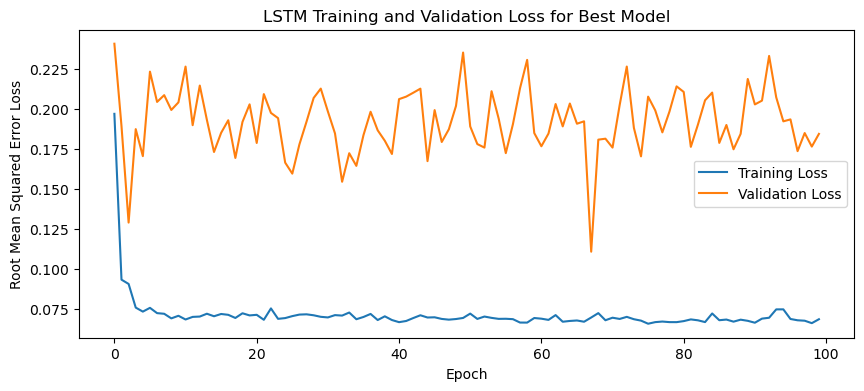

1/1 - 4s - loss: 0.0499 - 4s/epoch - 4s/step
Test Loss: 0.049949612468481064
1/1 [==============================] - 0s 63ms/step


IndexError: index 10 is out of bounds for axis 0 with size 10

In [3]:
n_batch = 1
nb_epoch = 100

def rmse (y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

def mape (y_true, y_pred):
    return 100*K.mean(K.sqrt(K.square(y_true - y_pred))/y_true)
    
def pearson (y_true, y_pred):
    return (K.square(K.mean((y_true - K.mean(y_true))*(y_pred - K.mean(y_pred)))))/(K.mean(K.square(y_true - K.mean(y_true)))*K.mean(K.square(y_pred - K.mean(y_pred))))
 
# fit an LSTM network to training data
#Adapted from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def create_model(trial, X, y, n_lag, n_seq, n_batch, nb_epoch):

    cv_accuracies = []
    
    #Parameters:
    #trial (array-like): Optuna parameters.
    #train (array-like): Target values.
    #n_lag (int): Number of lag observations.
    #n_seq (int): Number of sequence observations
    #nb_epoch (int): Maximum number of epochs
    
    # Hyperparameters to be tuned by Optuna (taken from Javier Leon's dissertation 'Fruit Prices')
    lr = trial.suggest_float('lr', 1e-3, 1, log=True)
    optimizer_name = trial.suggest_categorical('optimizer', ['Adam', 'RMSprop', 'SGD'])
    if optimizer_name == 'Adam':
        optimizer = Adam(learning_rate=lr)
    elif optimizer_name == 'RMSprop':
        optimizer = RMSprop(learning_rate=lr)
    else:
        optimizer = SGD(learning_rate=lr)
    
    #Optuna will try either Rectified Linear Unit (ReLU) = max(0, x), tanh, or sigmoid functions
    activation_function = trial.suggest_categorical('activation_function', ['relu', 'tanh', 'sigmoid'])
    
    lstm_units = trial.suggest_categorical('lstm_units', [256, 512, 1024])
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5)

    # design network
    model = Sequential()
    model.add(LSTM(lstm_units, return_sequences=True, batch_input_shape=(n_batch, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(lstm_units))
    model.add(Dropout(dropout_rate))
    model.add(Dense(256, input_dim=y.shape[1], activation=activation_function))
    model.add(Dense(128, activation=activation_function))
    model.add(Dense(n_seq))
    model.compile(loss=rmse, optimizer=optimizer)
        
    return model

# make forecast with the LSTM best model
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def forecast_lstm(model, X, n_seq, n_test):
    # reshape input pattern to [samples, timesteps, features]
    X = X.reshape(1, 1, X.shape[1])
    # make forecast
    forecast = model.predict(X)
    # convert to array
    return forecast
     
# evaluate the persistence model
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def make_forecasts(model, X_test, y_test, n_lag, n_seq, n_test):
    forecasts = list()
    for i in range(len(X_test)):
        X, y = X_test[i, :], y_test[i, :]
        # make forecast
        forecast = forecast_lstm(model, X, n_seq, n_test)
        # store the forecast
        forecasts.append(forecast)
    return forecasts
     
# invert differenced forecast
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def inverse_difference(last_ob, forecast):
    # invert first forecast
    inverted = list()
    inverted.append(forecast[0] + last_ob)
    # propagate difference forecast using inverted first value
    for i in range(1, len(forecast)):
        inverted.append(forecast[i] + inverted[i-1])
    return inverted
     
# inverse data transform on forecasts
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def inverse_transform(series, forecasts, scaler, n_test, n_seq):
    inverted = list()
    for i in range(len(forecasts)):
        # create array from forecast
        forecast = forecasts[i]
        forecast = forecast.reshape(1, n_seq)
        # invert scaling
        inv_scale = scaler.inverse_transform(forecast)
        inv_scale = inv_scale[0, :]
        # invert differencing
        index = len(series) - n_test + i - 1
        last_ob = series.values[index]
        inv_diff = inverse_difference(last_ob, inv_scale)
        # store
        inverted.append(inv_diff)
    return inverted
     
# evaluate the RMSE for each forecast time step
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def evaluate_forecasts(test, forecasts, n_lag, n_seq):
    rmse_list = []
    mae_list = []
    mape_list = []
    r2_list = []
    for i in range(n_seq):
        actual = [row[i] for row in test]
        predicted = [forecast[i] for forecast in forecasts]
        rmse = sqrt(mean_squared_error(actual, predicted))
        mae = mean_absolute_error(actual, predicted)
        mse = mean_squared_error(actual, predicted)
        mape = mean_absolute_percentage_error(actual, predicted)
        r2 = r2_score(actual, predicted) 
        rmse_list.append(rmse)
        mae_list.append(mae)
        mape_list.append(mape)
        r2_list.append(r2)
        print("Month at t+"+str(i+1)+":")
        print('t+%d RMSE: %f' % ((i+1), rmse))
        print('t+%d MAE: %f' % ((i+1), mae))
        print('t+%d MAPE: %f' % ((i+1), mape))
        print('t+%d R2_SCORE: %f' % ((i+1), r2))

    return rmse_list, mae_list, mape_list, r2_list
     
# plot the forecasts in the context of the original dataset
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def plot_forecasts(series, forecasts, n_test):
    # plot the entire dataset in blue
    plt.plot(series.values)
    # plot the forecasts in red
    for i in range(len(forecasts)):
        off_s = len(series) - n_test + i - 1
        off_e = off_s + len(forecasts[i]) + 1
        xaxis = [x for x in range(off_s, off_e)]
        yaxis = [series.values[off_s]] + forecasts[i]
        plt.plot(xaxis, yaxis, color='red')
    # show the plot
    plt.show()
    
def objective(trial):
    
    cv_accuracies = []
        
    for i in range(5):
        train1 = train[i]
        test1 = test[i]
        validation1 = validation[i]

        X, y = train1[:, 0:-n_seq], train1[:, -n_seq:]
        X_test, y_test = test1[:, 0:-n_seq], test1[:, -n_seq:]
        X_val, y_val = validation1[:, 0:-n_seq], validation1[:, -n_seq:]
        X = X.reshape(X.shape[0], 1, X.shape[1])
        X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
        X_val = X_val.reshape(X_val.shape[0], 1, X_val.shape[1])
    
        model = create_model(trial, X, y, n_lag, n_seq, n_batch, nb_epoch)

        history = model.fit(X, y, validation_data=(X_val, y_val), epochs=nb_epoch, verbose=0)

        cv_accuracy = model.evaluate(X_test, y_test, verbose=0)
    
        loss = history.history['val_loss'][-1]
    
        # Plotting the training and validation loss
        #plt.figure(figsize=(10, 4))
        #plt.plot(history.history['loss'], label='Training Loss')
        #plt.plot(history.history['val_loss'], label='Validation Loss')
        #title1 = "LSTM Training and Validation Loss for Fold " + str(i+1)
        #plt.title(title1)
        #plt.xlabel('Epoch')
        #plt.ylabel('Root Mean Squared Error Loss')
        #plt.legend()
        #plt.show()
            
        cv_accuracies.append(cv_accuracy)
    
    print("Cross Validation Accuracies:")
    print(cv_accuracies)
    print("Mean Cross Validation Accuracy:")
    print(np.mean(cv_accuracies))
    print("Standard Deviation of Cross Validation Accuracy:")
    print(np.std(cv_accuracies))
        
    return np.mean(cv_accuracies)

n_batch = 1
nb_epoch = 100

# optimize and fit model
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)
print('Number of finished trials:', len(study.trials))

print('Best trial:', study.best_trial.params)
best_params = study.best_params
print("Best hyperparameters: ", best_params)

for i in range(5):
    print("Fold "+str(i+1)+":")
    train1 = train[i]
    test1 = test[i]
    validation1 = validation[i]

    X, y = train1[:, 0:-n_seq], train1[:, -n_seq:]
    X_test, y_test = test1[:, 0:-n_seq], test1[:, -n_seq:]
    X_val, y_val = validation1[:, 0:-n_seq], validation1[:, -n_seq]

    dataset_df = pd.DataFrame(val_y[i])
    dataset_df = dataset_df.iloc[0:10, :]
    dataset = dataset_df.values

    series = pd.Series(dataset[:, 0]) # Using first column (temperatures)
    
    X = X.reshape(X.shape[0], 1, X.shape[1])
    X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
    X_val = X_val.reshape(X_val.shape[0], 1, X_val.shape[1])

    best_model = create_model(optuna.trial.FixedTrial(best_params), X, y, n_lag, n_seq, n_batch, nb_epoch)
    history=best_model.fit(X, y, epochs=nb_epoch, batch_size=n_batch, validation_data=(X_val, y_val))

    # Plotting the training and validation loss
    plt.figure(figsize=(10, 4))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    title1 = "LSTM Training and Validation Loss for Best Model"
    plt.title(title1)
    plt.xlabel('Epoch')
    plt.ylabel('Root Mean Squared Error Loss')
    plt.legend()
    plt.show()

    # Evaluate the model
    loss = best_model.evaluate(X_test, y_test, verbose=2)
    print(f'Test Loss: {loss}')

    # make forecasts
    forecasts = make_forecasts(best_model, X_test, y_test, n_lag, n_seq, n_test)
    
    # inverse transform forecasts and test
    forecasts = inverse_transform(series, forecasts, scaler[i], n_test+2, n_seq)
    actual = [row[-n_seq:] for row in test1]
    actual = inverse_transform(series, actual, scaler[i], n_test+2, n_seq)

    rmse_list = [] # list stores root mean squared errors for each future time prediction
    mae_list = [] # list stores root mean squared errors for each future time prediction
    mape_list = [] # list stores root mean squared errors for each future time prediction
    r2_list = [] # list stores root mean squared errors for each future time prediction
    
    # evaluate forecasts
    rmse_list, mae_list, mape_list, r2_list = evaluate_forecasts(actual, forecasts, n_lag, n_seq)

    for j in range(len(X_test)):
        print("Weather Station "+str(j+1)+":")
        dataset_df = pd.DataFrame(y_test[j].flatten())
        dataset = dataset_df.values
        dataset = dataset[:, 0]
        dataset = np.array(dataset).reshape(-1, 1)
        dataset = dataset.flatten()
        dataset = pd.DataFrame(dataset)
        series = scaler[i].inverse_transform(dataset)
        series = pd.Series(series.flatten())

    # plot forecasts
    plot_forecasts(series, forecasts, 1)
    
    best_model.summary()

    # Print out table of actual and predicted values for each weather station
    for j in range(11):
        print("Weather Station "+str(j+1)+":")
        print("Actual S.H.\tPredicted S.H.\tDifference")
        print("-----------\t--------------\t----------")
        for k in range(n_seq):
            diff = forecasts[j][k] - actual[j][k]
            print(f"{actual[j][k]:.2f}\t\t{forecasts[j][k]:.2f}\t\t{diff:.2f}")

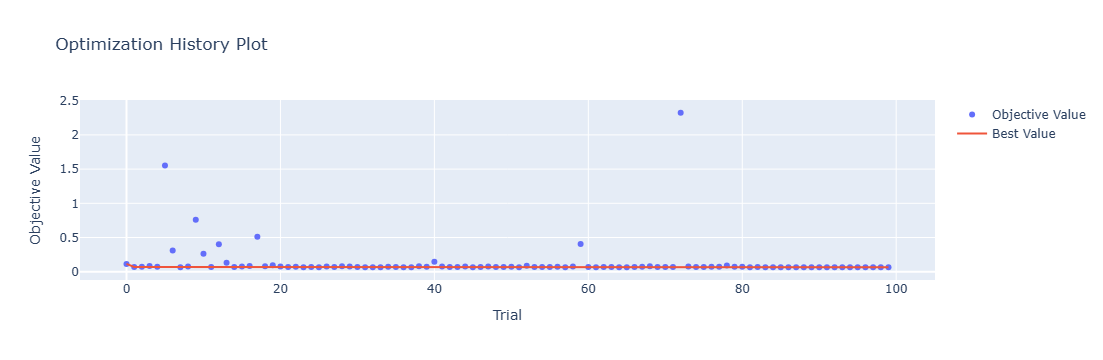

In [4]:
optuna.visualization.plot_optimization_history(study)

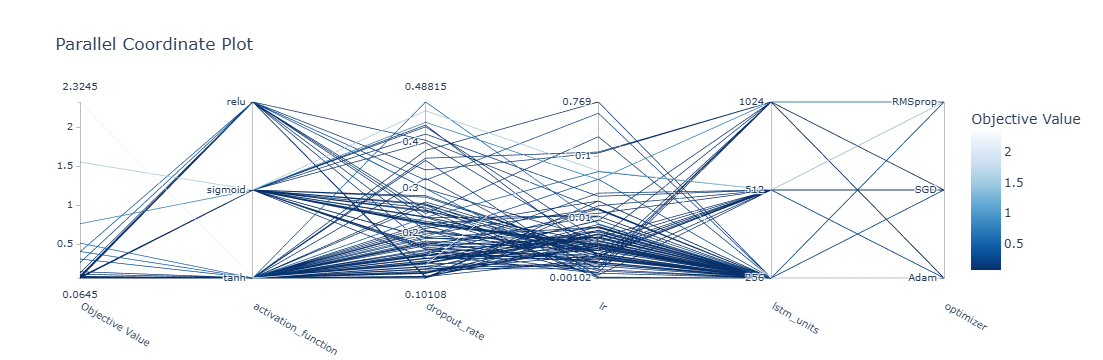

In [5]:
optuna.visualization.plot_parallel_coordinate(study)

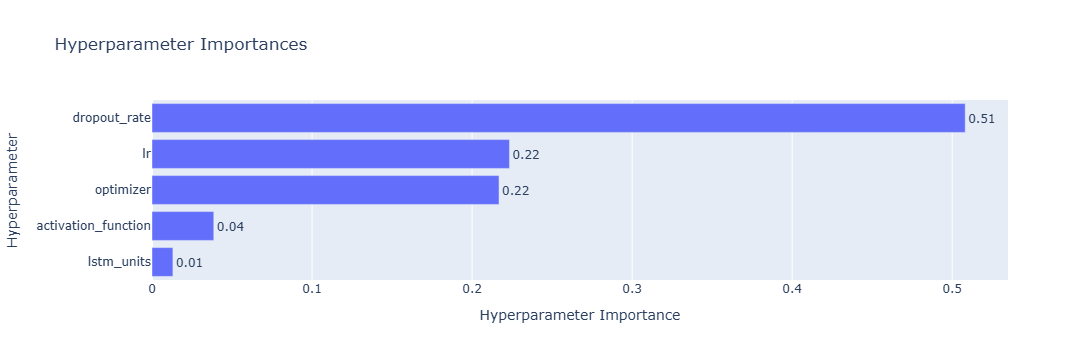

In [6]:
optuna.visualization.plot_param_importances(study)

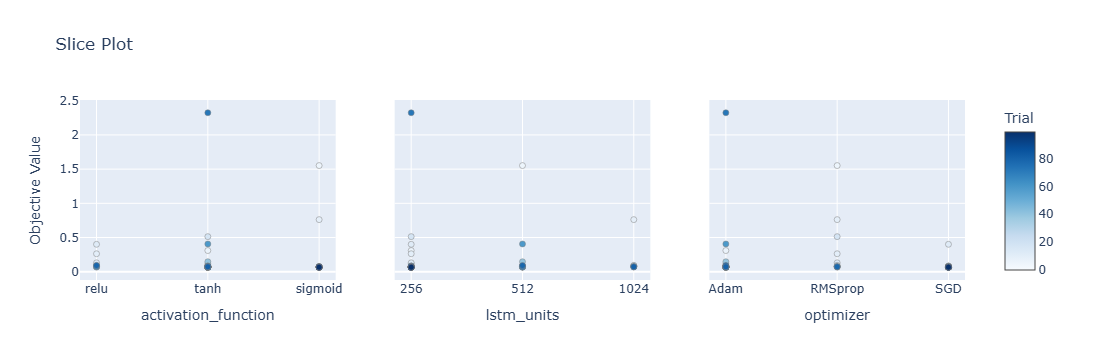

In [7]:
optuna.visualization.plot_slice(study, params=['optimizer', 'activation_function', 'lstm_units'])

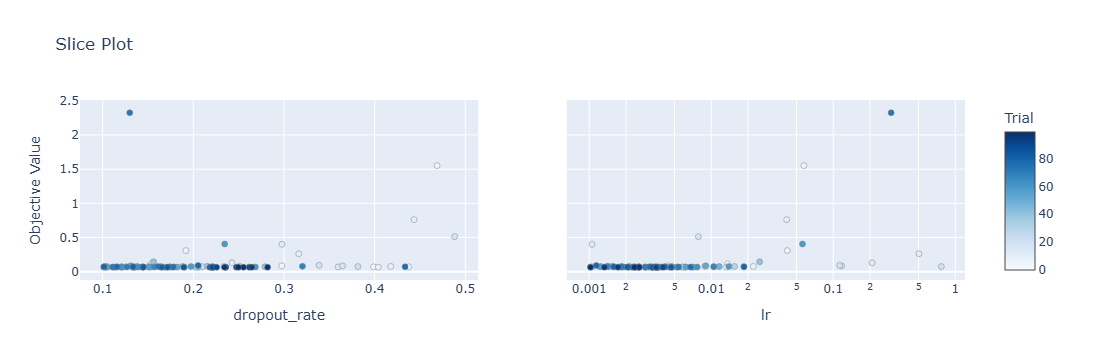

In [8]:
optuna.visualization.plot_slice(study, params=['lr', 'dropout_rate'])

Epoch 1/100
84/84 [==============================] - 30s 153ms/step - loss: 0.1997 - accuracy: 0.4405 - mae: 0.1684 - rmse: 0.1997 - mape: 28.5351 - pearson: 0.4858 - val_loss: 0.0812 - val_accuracy: 0.6000 - val_mae: 0.0672 - val_rmse: 0.0812 - val_mape: 12.4929 - val_pearson: 0.7465
Epoch 2/100
84/84 [==============================] - 6s 70ms/step - loss: 0.0833 - accuracy: 0.6905 - mae: 0.0687 - rmse: 0.0833 - mape: 12.1098 - pearson: 0.7385 - val_loss: 0.0742 - val_accuracy: 0.6000 - val_mae: 0.0576 - val_rmse: 0.0742 - val_mape: 10.2649 - val_pearson: 0.7954
Epoch 3/100
84/84 [==============================] - 6s 69ms/step - loss: 0.0829 - accuracy: 0.7262 - mae: 0.0671 - rmse: 0.0829 - mape: 11.7050 - pearson: 0.7704 - val_loss: 0.0973 - val_accuracy: 0.6000 - val_mae: 0.0842 - val_rmse: 0.0973 - val_mape: 14.3230 - val_pearson: 0.7559
Epoch 4/100
84/84 [==============================] - 6s 69ms/step - loss: 0.0767 - accuracy: 0.7262 - mae: 0.0614 - rmse: 0.0767 - mape: 10.7073 -

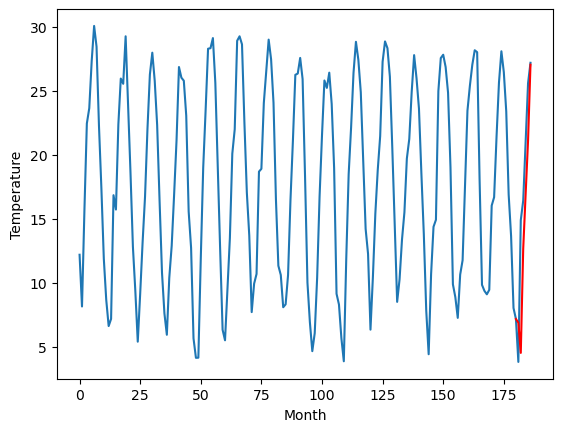

Weather Station 2:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
8.53		5.92		-2.61
8.44		3.57		-4.87
13.50		11.69		-1.81
14.90		15.96		1.06
18.92		20.16		1.24
22.40		26.07		3.67
[180, 181, 182, 183, 184, 185, 186]
[13.23, 5.924755687713623, 3.5656532001495362, 11.691857690811158, 15.962761278152467, 20.155253763198854, 26.070440645217897]


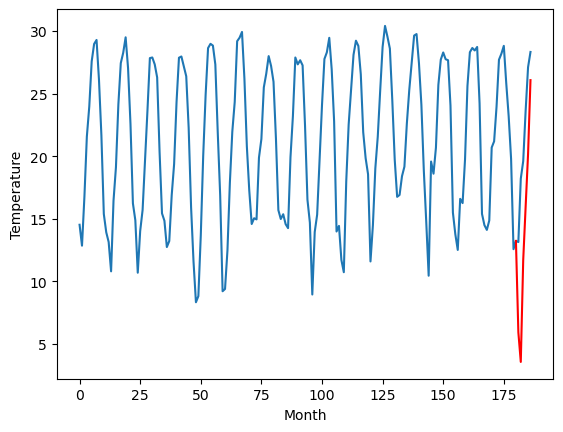

Weather Station 3:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
7.31		4.54		-2.77
8.17		2.19		-5.98
14.15		10.31		-3.84
15.79		14.58		-1.21
19.77		18.78		-0.99
23.91		24.69		0.78
[180, 181, 182, 183, 184, 185, 186]
[7.18, 4.544755687713623, 2.1856532001495363, 10.311857690811157, 14.582761278152466, 18.775253763198855, 24.690440645217897]


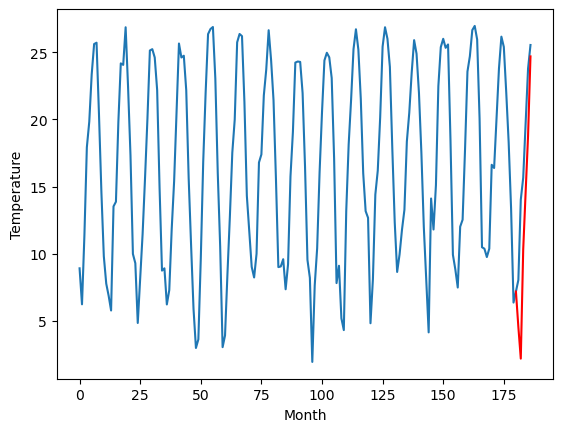

Weather Station 4:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
5.38		3.34		-2.04
3.81		0.99		-2.82
11.72		9.11		-2.61
13.51		13.38		-0.13
17.48		17.58		0.10
20.76		23.49		2.73
[180, 181, 182, 183, 184, 185, 186]
[11.46, 3.344755687713623, 0.9856532001495362, 9.111857690811156, 13.382761278152465, 17.57525376319885, 23.490438737869262]


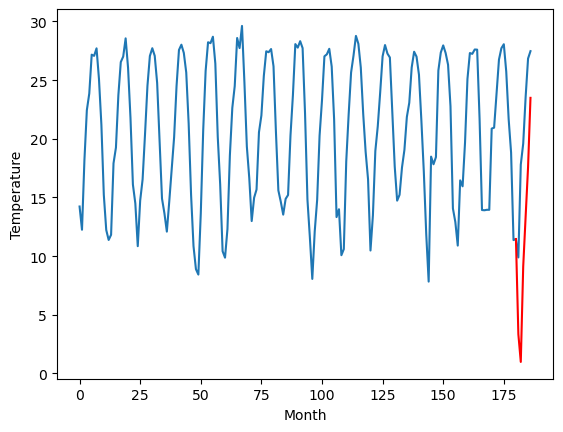

Weather Station 5:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
11.33		10.26		-1.07
8.24		7.91		-0.33
18.14		16.03		-2.11
20.07		20.30		0.23
23.93		24.50		0.57
29.13		30.41		1.28
[180, 181, 182, 183, 184, 185, 186]
[9.27, 10.264755687713624, 7.905653200149537, 16.031857690811158, 20.302761278152467, 24.495253763198853, 30.410440645217896]


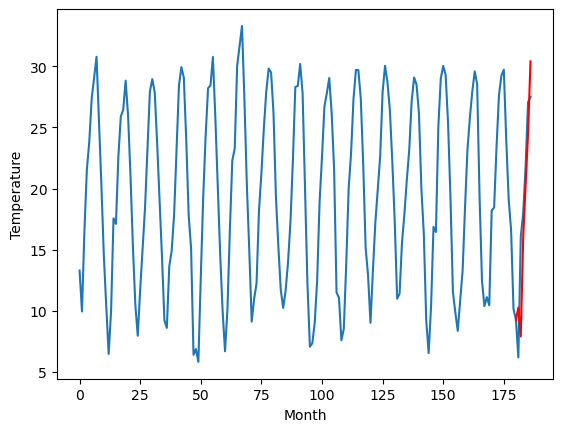

Weather Station 6:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
12.74		12.57		-0.17
13.39		10.22		-3.17
18.29		18.34		0.05
21.66		22.61		0.95
25.17		26.81		1.64
29.74		32.72		2.98
[180, 181, 182, 183, 184, 185, 186]
[7.77, 12.574755687713623, 10.215653200149536, 18.341857690811157, 22.612763185501098, 26.805255670547485, 32.720442552566524]


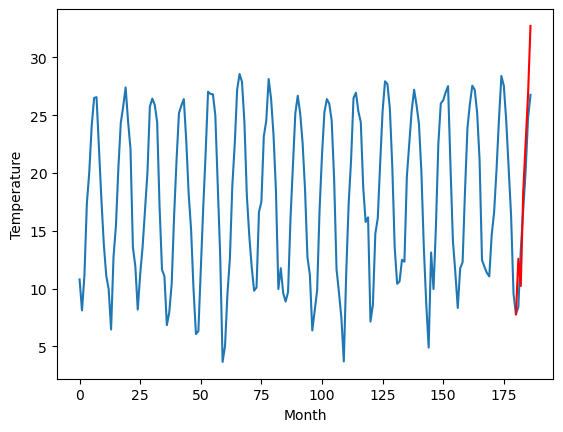

Weather Station 7:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
8.33		6.96		-1.37
8.97		4.61		-4.36
15.95		12.73		-3.22
16.98		17.00		0.02
20.69		21.20		0.51
25.02		27.11		2.09
[180, 181, 182, 183, 184, 185, 186]
[6.59, 6.964755687713623, 4.605654153823853, 12.731858644485474, 17.002764139175415, 21.195256624221802, 27.110443506240845]


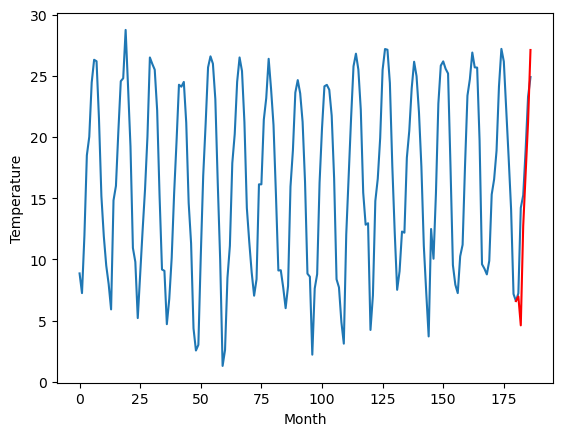

Weather Station 8:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
13.29		12.28		-1.01
13.91		9.93		-3.98
20.43		18.05		-2.38
24.06		22.32		-1.74
27.08		26.52		-0.56
31.87		32.43		0.56
[180, 181, 182, 183, 184, 185, 186]
[5.3, 12.284755687713623, 9.925653200149537, 18.051857690811158, 22.3227631855011, 26.515255670547486, 32.43044255256653]


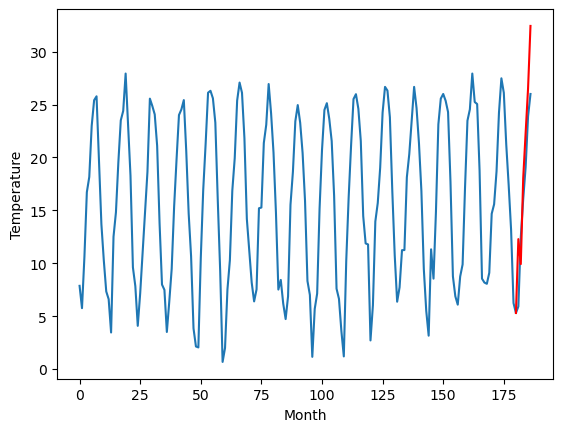

Weather Station 9:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
12.51		11.35		-1.16
8.24		9.00		0.76
20.71		17.12		-3.59
23.31		21.39		-1.92
28.00		25.59		-2.41
34.19		31.50		-2.69
[180, 181, 182, 183, 184, 185, 186]
[3.1, 11.354755687713624, 8.995654153823853, 17.121858644485474, 21.392764139175416, 25.585256624221802, 31.500443506240845]


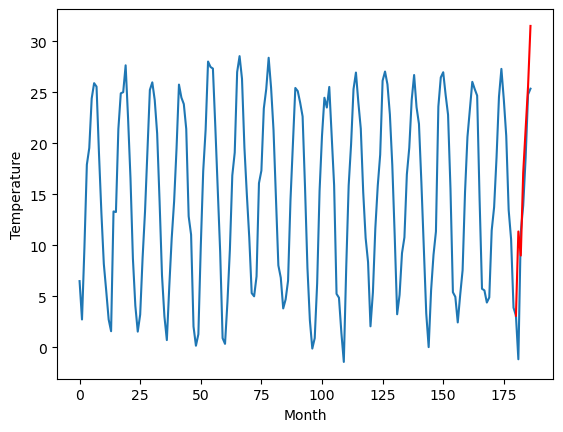

Weather Station 10:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
9.20		8.84		-0.36
7.03		6.49		-0.54
17.78		14.61		-3.17
20.84		18.88		-1.96
25.31		23.08		-2.23
31.79		28.99		-2.80
[180, 181, 182, 183, 184, 185, 186]
[0.6, 8.844755687713622, 6.485654153823852, 14.611858644485473, 18.882764139175414, 23.0752566242218, 28.990443506240844]


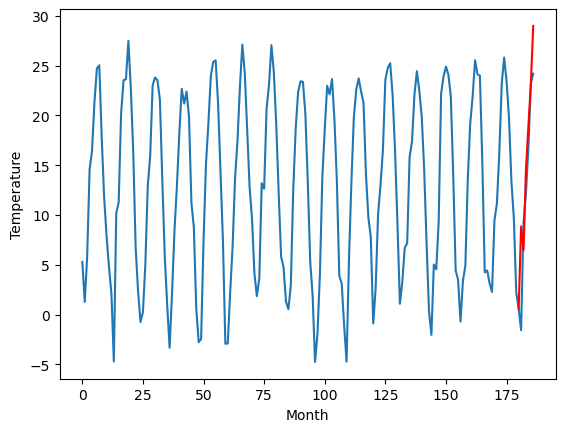

Weather Station 11:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
7.24		6.90		-0.34
2.93		4.55		1.62
14.66		12.67		-1.99
18.63		16.94		-1.69
23.78		21.14		-2.64
31.09		27.05		-4.04
[180, 181, 182, 183, 184, 185, 186]
[-0.75, 6.904755687713623, 4.545654153823852, 12.671858644485473, 16.942764139175416, 21.135256624221803, 27.050443506240846]


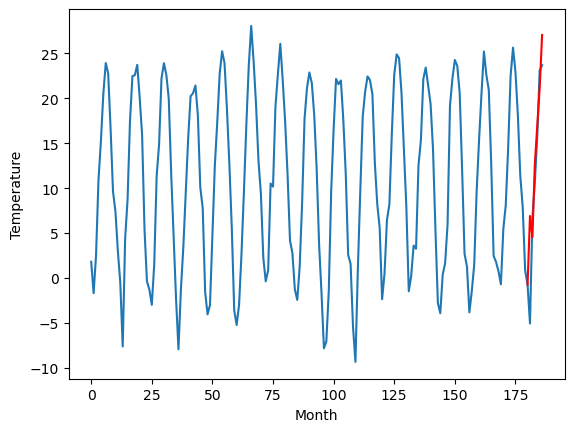

RangeIndex(start=1, stop=12, step=1)
[7.989999999999999, 8.53, 7.310000000000001, 5.3800000000000034, 11.33, 12.739999999999998, 8.33, 13.29, 12.51, 9.2, 7.24]
[6.904755687713623, 5.924755687713623, 4.544755687713623, 3.344755687713623, 10.264755687713624, 12.574755687713623, 6.964755687713623, 12.284755687713623, 11.354755687713624, 8.844755687713622, 6.904755687713623]
Predictions for (t+0):
    Weather_Station  Actual  Predicted
0                 0    7.99   6.904756
1                 1    8.53   5.924756
2                 2    7.31   4.544756
3                 3    5.38   3.344756
4                 4   11.33  10.264756
5                 5   12.74  12.574756
6                 6    8.33   6.964756
7                 7   13.29  12.284756
8                 8   12.51  11.354756
9                 9    9.20   8.844756
10               10    7.24   6.904756


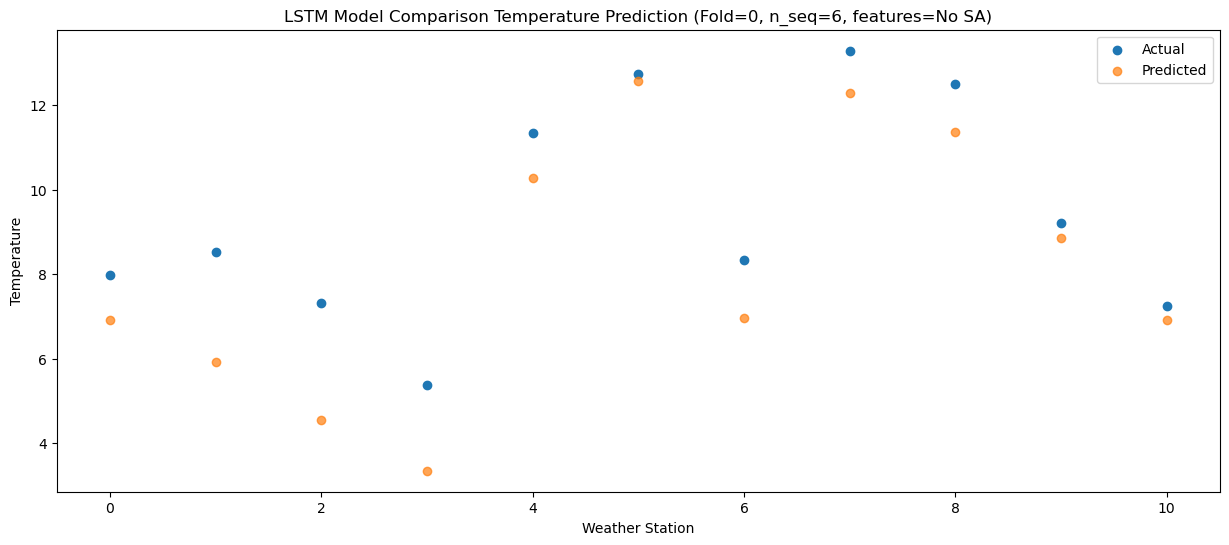

Predictions for (t+1):
    Weather_Station  Actual  Predicted
0                 0    4.64   4.545653
1                 1    8.44   3.565653
2                 2    8.17   2.185653
3                 3    3.81   0.985653
4                 4    8.24   7.905653
5                 5   13.39  10.215653
6                 6    8.97   4.605654
7                 7   13.91   9.925653
8                 8    8.24   8.995654
9                 9    7.03   6.485654
10               10    2.93   4.545654


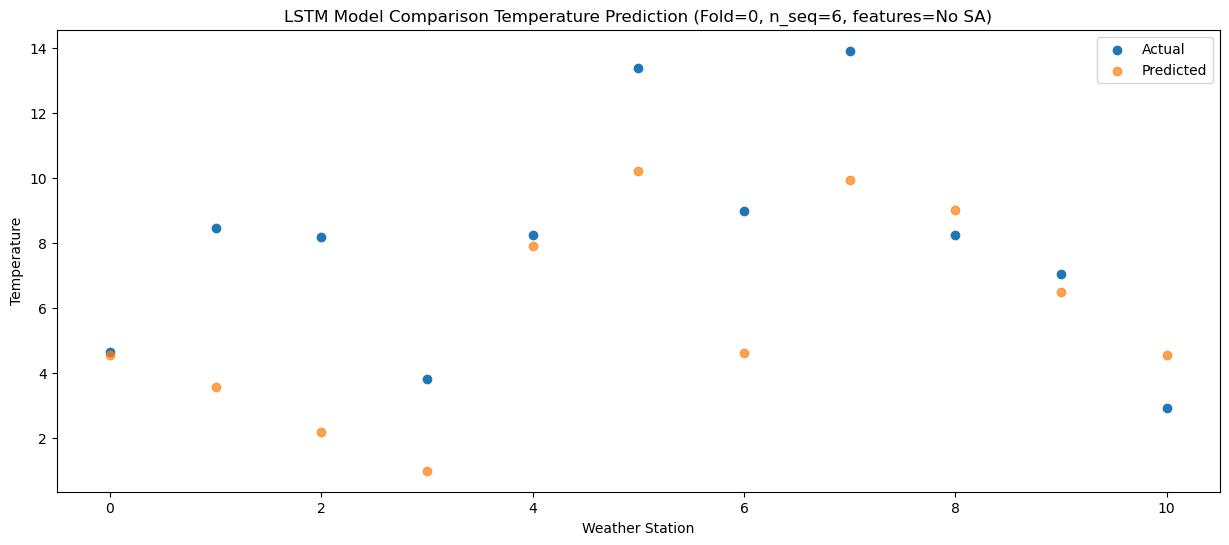

Predictions for (t+2):
    Weather_Station  Actual  Predicted
0                 0   15.71  12.671858
1                 1   13.50  11.691858
2                 2   14.15  10.311858
3                 3   11.72   9.111858
4                 4   18.14  16.031858
5                 5   18.29  18.341858
6                 6   15.95  12.731859
7                 7   20.43  18.051858
8                 8   20.71  17.121859
9                 9   17.78  14.611859
10               10   14.66  12.671859


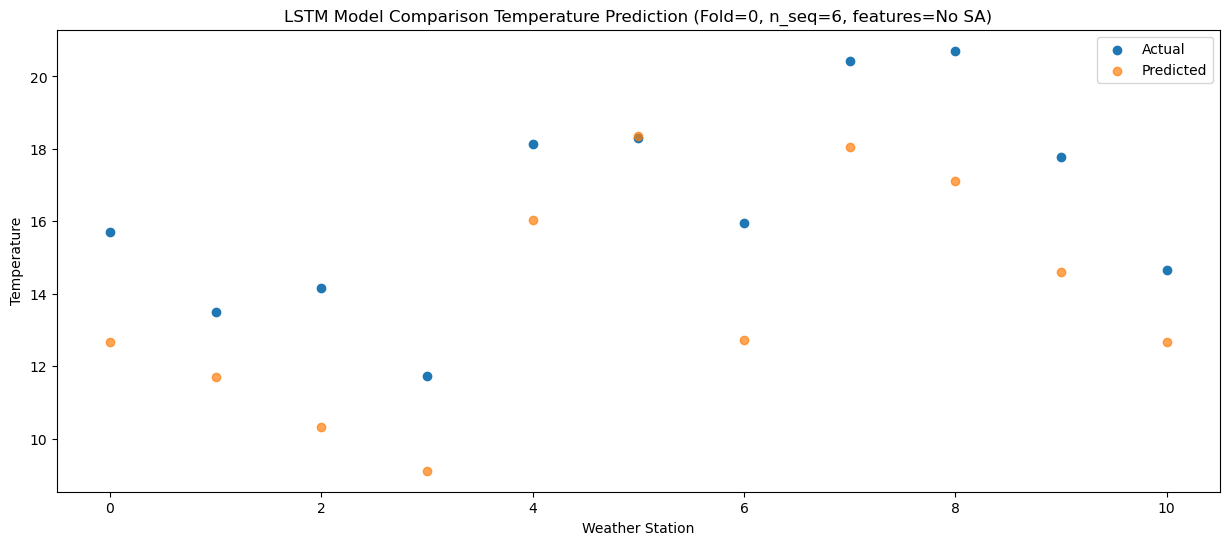

Predictions for (t+3):
    Weather_Station  Actual  Predicted
0                 0   17.24  16.942761
1                 1   14.90  15.962761
2                 2   15.79  14.582761
3                 3   13.51  13.382761
4                 4   20.07  20.302761
5                 5   21.66  22.612763
6                 6   16.98  17.002764
7                 7   24.06  22.322763
8                 8   23.31  21.392764
9                 9   20.84  18.882764
10               10   18.63  16.942764


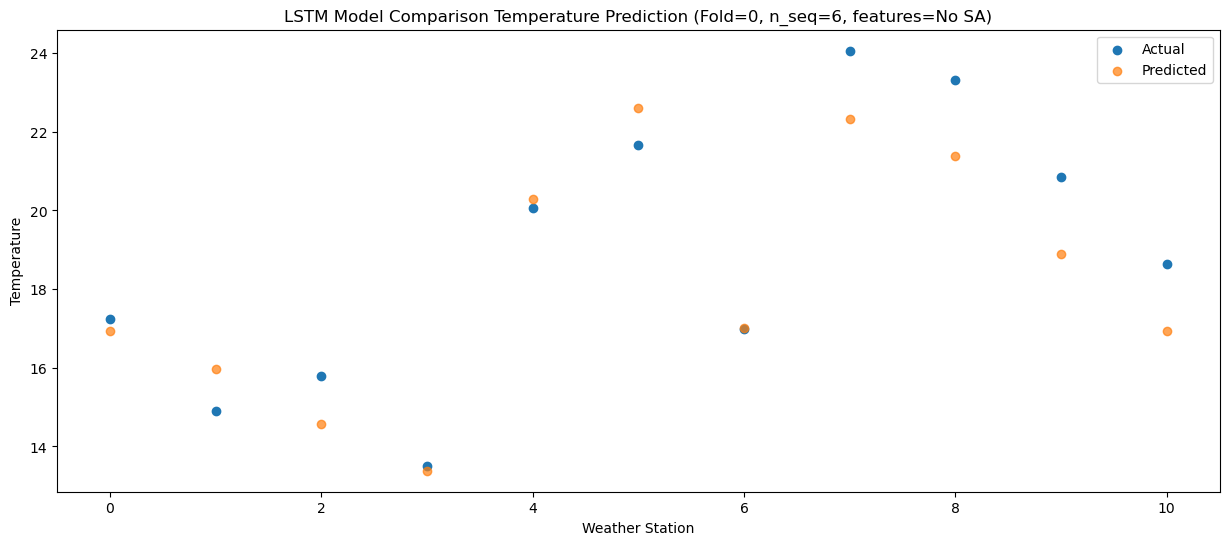

Predictions for (t+4):
    Weather_Station  Actual  Predicted
0                 0   21.74  21.135254
1                 1   18.92  20.155254
2                 2   19.77  18.775254
3                 3   17.48  17.575254
4                 4   23.93  24.495254
5                 5   25.17  26.805256
6                 6   20.69  21.195257
7                 7   27.08  26.515256
8                 8   28.00  25.585257
9                 9   25.31  23.075257
10               10   23.78  21.135257


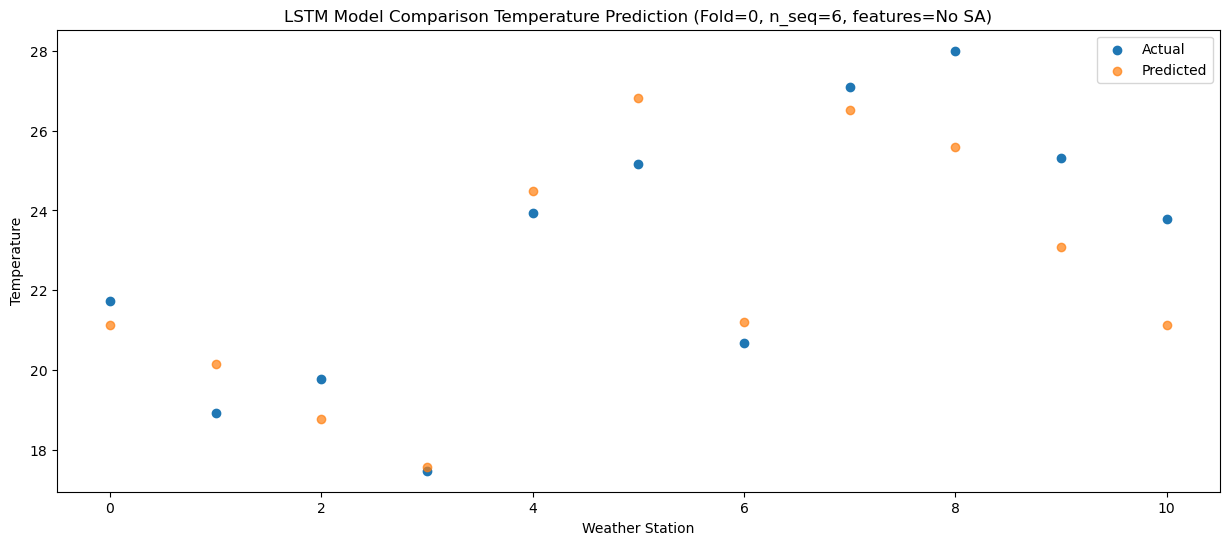

Predictions for (t+5):
    Weather_Station  Actual  Predicted
0                 0   26.41  27.050439
1                 1   22.40  26.070441
2                 2   23.91  24.690441
3                 3   20.76  23.490439
4                 4   29.13  30.410441
5                 5   29.74  32.720443
6                 6   25.02  27.110444
7                 7   31.87  32.430443
8                 8   34.19  31.500444
9                 9   31.79  28.990444
10               10   31.09  27.050444


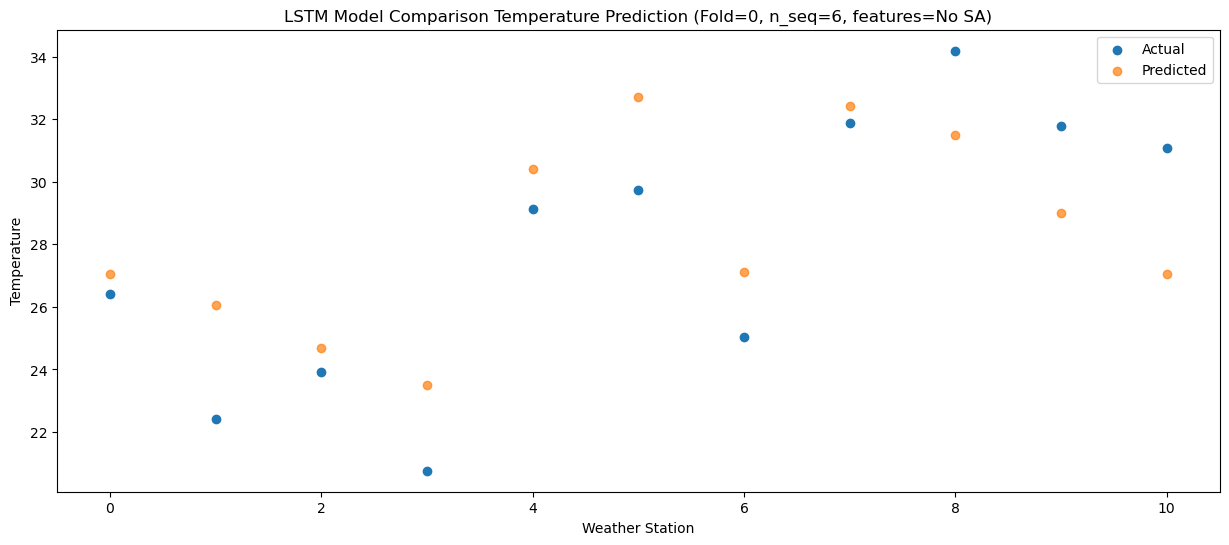

Model: "sequential_503"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1006 (LSTM)            (1, 1, 256)               2279424   
                                                                 
 dropout_1006 (Dropout)      (1, 1, 256)               0         
                                                                 
 lstm_1007 (LSTM)            (1, 256)                  525312    
                                                                 
 dropout_1007 (Dropout)      (1, 256)                  0         
                                                                 
 dense_1509 (Dense)          (1, 256)                  65792     
                                                                 
 dense_1510 (Dense)          (1, 128)                  32896     
                                                                 
 dense_1511 (Dense)          (1, 6)                 

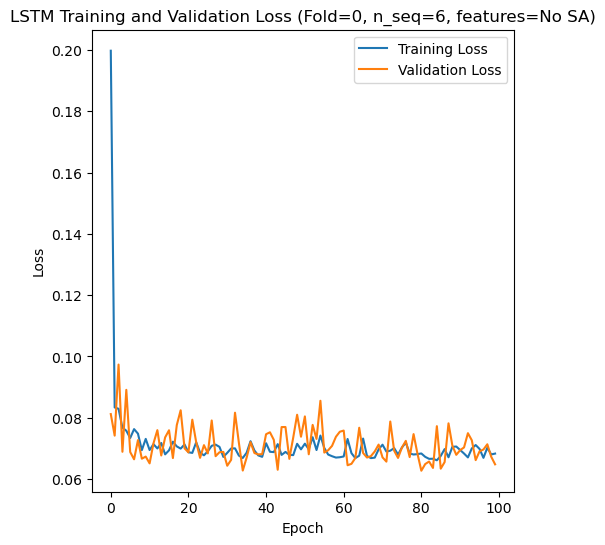

Epoch 1/100
84/84 [==============================] - 40s 154ms/step - loss: 0.1962 - accuracy: 0.4524 - mae: 0.1616 - rmse: 0.1962 - mape: 27.8390 - pearson: 0.4804 - val_loss: 0.1090 - val_accuracy: 0.8000 - val_mae: 0.1006 - val_rmse: 0.1090 - val_mape: 17.3337 - val_pearson: 0.7543
Epoch 2/100
84/84 [==============================] - 4s 51ms/step - loss: 0.0907 - accuracy: 0.6786 - mae: 0.0749 - rmse: 0.0907 - mape: 13.0384 - pearson: 0.7338 - val_loss: 0.1074 - val_accuracy: 0.8000 - val_mae: 0.0873 - val_rmse: 0.1074 - val_mape: 13.8345 - val_pearson: 0.7879
Epoch 3/100
84/84 [==============================] - 4s 49ms/step - loss: 0.0821 - accuracy: 0.6548 - mae: 0.0667 - rmse: 0.0821 - mape: 11.5822 - pearson: 0.7395 - val_loss: 0.0959 - val_accuracy: 0.8000 - val_mae: 0.0846 - val_rmse: 0.0959 - val_mape: 14.0747 - val_pearson: 0.8158
Epoch 4/100
84/84 [==============================] - 4s 51ms/step - loss: 0.0792 - accuracy: 0.6667 - mae: 0.0648 - rmse: 0.0792 - mape: 11.3657 -

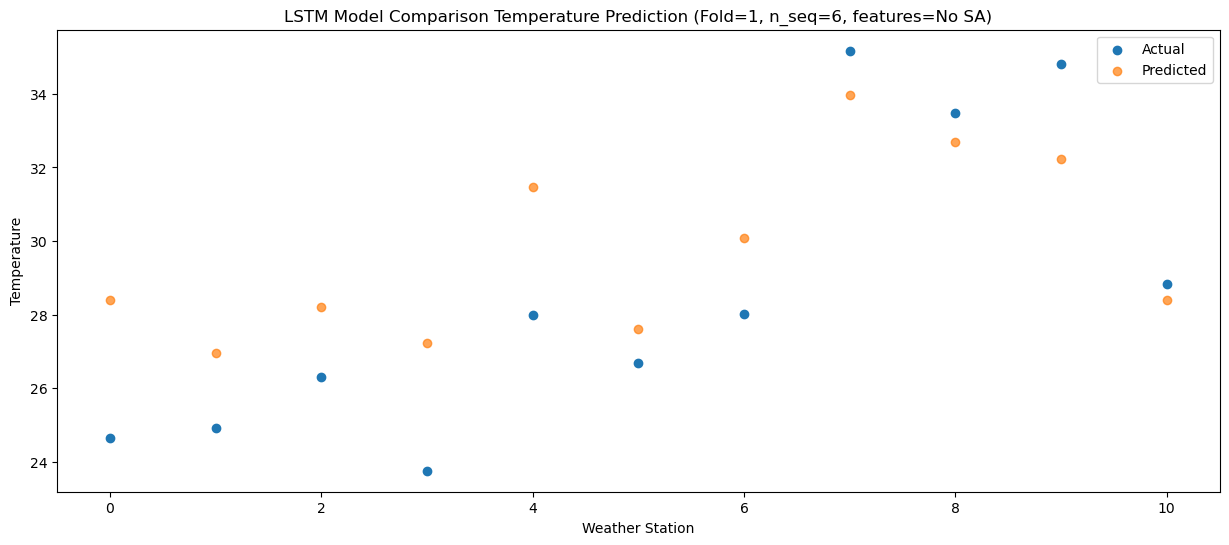

Model: "sequential_504"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1008 (LSTM)            (1, 1, 256)               2279424   
                                                                 
 dropout_1008 (Dropout)      (1, 1, 256)               0         
                                                                 
 lstm_1009 (LSTM)            (1, 256)                  525312    
                                                                 
 dropout_1009 (Dropout)      (1, 256)                  0         
                                                                 
 dense_1512 (Dense)          (1, 256)                  65792     
                                                                 
 dense_1513 (Dense)          (1, 128)                  32896     
                                                                 
 dense_1514 (Dense)          (1, 6)                 

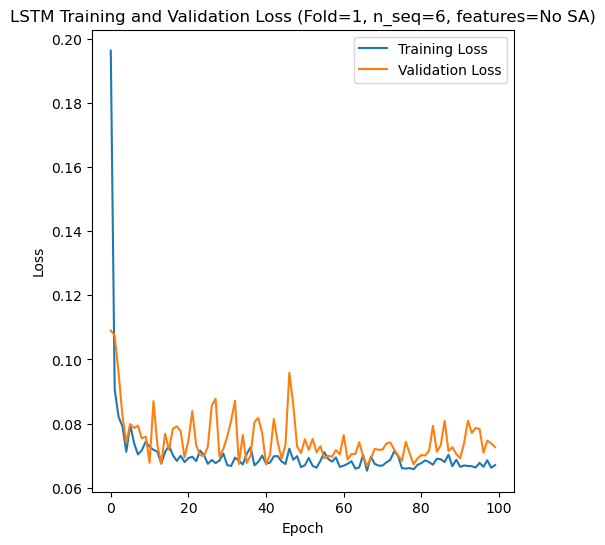

Epoch 1/100
84/84 [==============================] - 36s 126ms/step - loss: 0.2125 - accuracy: 0.4286 - mae: 0.1772 - rmse: 0.2125 - mape: 30.3912 - pearson: 0.4693 - val_loss: 0.1052 - val_accuracy: 0.9000 - val_mae: 0.0909 - val_rmse: 0.1052 - val_mape: 15.0533 - val_pearson: 0.5161
Epoch 2/100
84/84 [==============================] - 3s 40ms/step - loss: 0.0906 - accuracy: 0.6310 - mae: 0.0741 - rmse: 0.0906 - mape: 12.8187 - pearson: 0.7192 - val_loss: 0.0611 - val_accuracy: 0.9000 - val_mae: 0.0502 - val_rmse: 0.0611 - val_mape: 9.2169 - val_pearson: 0.9044
Epoch 3/100
84/84 [==============================] - 3s 39ms/step - loss: 0.0794 - accuracy: 0.6667 - mae: 0.0633 - rmse: 0.0794 - mape: 11.1123 - pearson: 0.7578 - val_loss: 0.0487 - val_accuracy: 0.9000 - val_mae: 0.0421 - val_rmse: 0.0487 - val_mape: 7.1028 - val_pearson: 0.9008
Epoch 4/100
84/84 [==============================] - 4s 44ms/step - loss: 0.0766 - accuracy: 0.7857 - mae: 0.0616 - rmse: 0.0766 - mape: 10.9064 - p

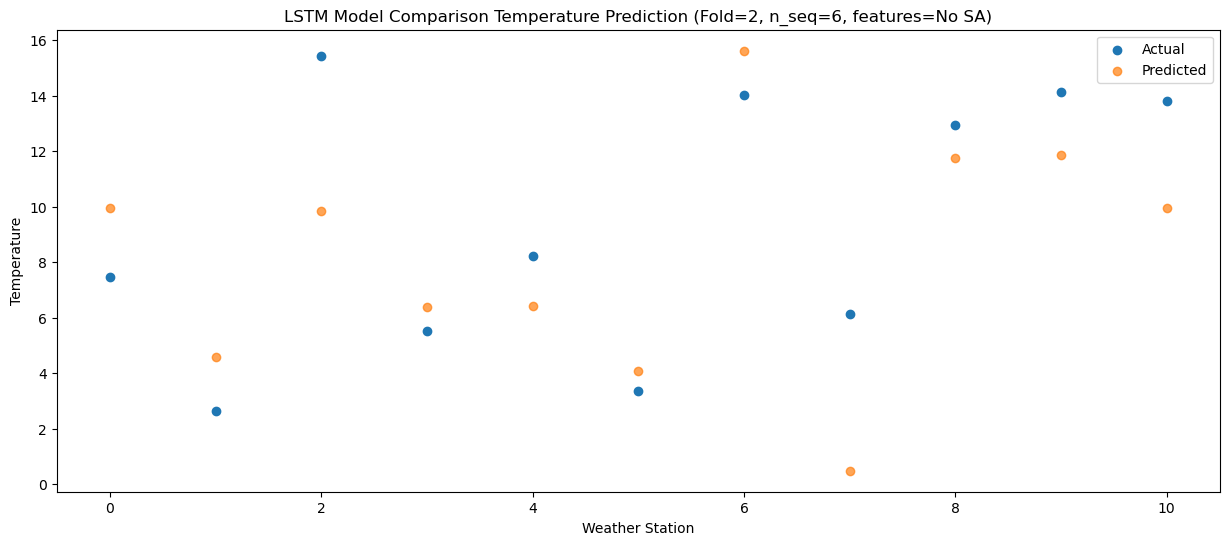

Predictions for (t+2):
    Weather_Station  Actual  Predicted
0                 0   19.90  20.023149
1                 1   12.84  14.653147
2                 2   17.24  19.923149
3                 3    9.62  16.453147
4                 4   15.55  16.493149
5                 5   11.72  14.163147
6                 6   24.38  25.703147
7                 7    9.24  10.563147
8                 8   12.56  21.823149
9                 9   21.02  21.933149
10               10   20.03  20.023149


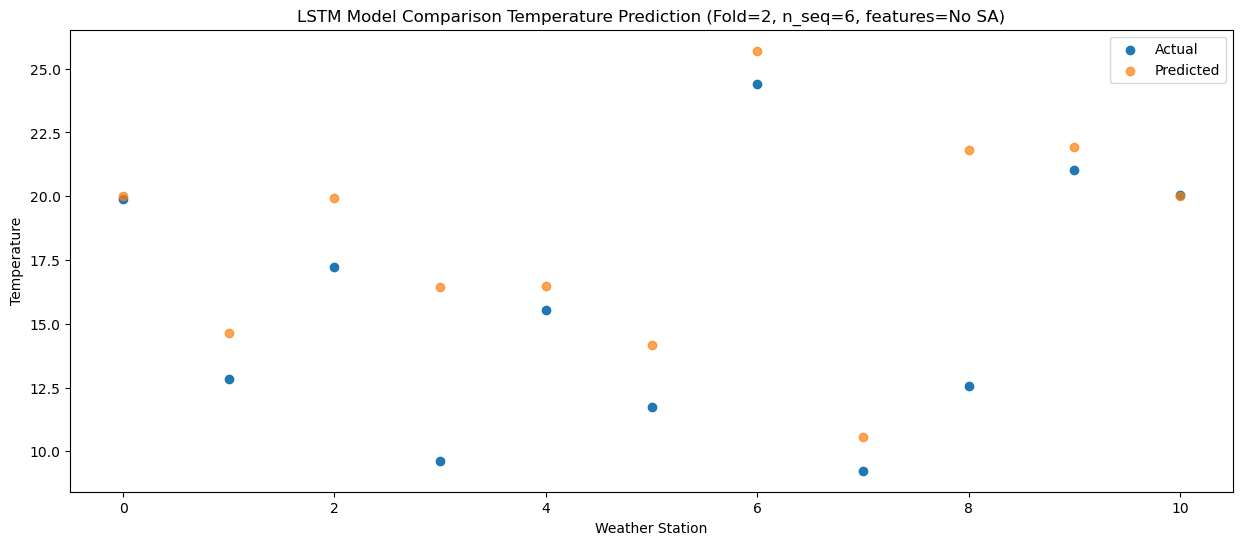

Predictions for (t+3):
    Weather_Station  Actual  Predicted
0                 0   21.77  23.653024
1                 1   16.60  18.283022
2                 2   19.05  23.553024
3                 3   14.12  20.083022
4                 4   16.42  20.123024
5                 5   13.84  17.793022
6                 6   26.08  29.333022
7                 7   15.90  14.193022
8                 8   16.42  25.453024
9                 9   23.81  25.563024
10               10   22.00  23.653024


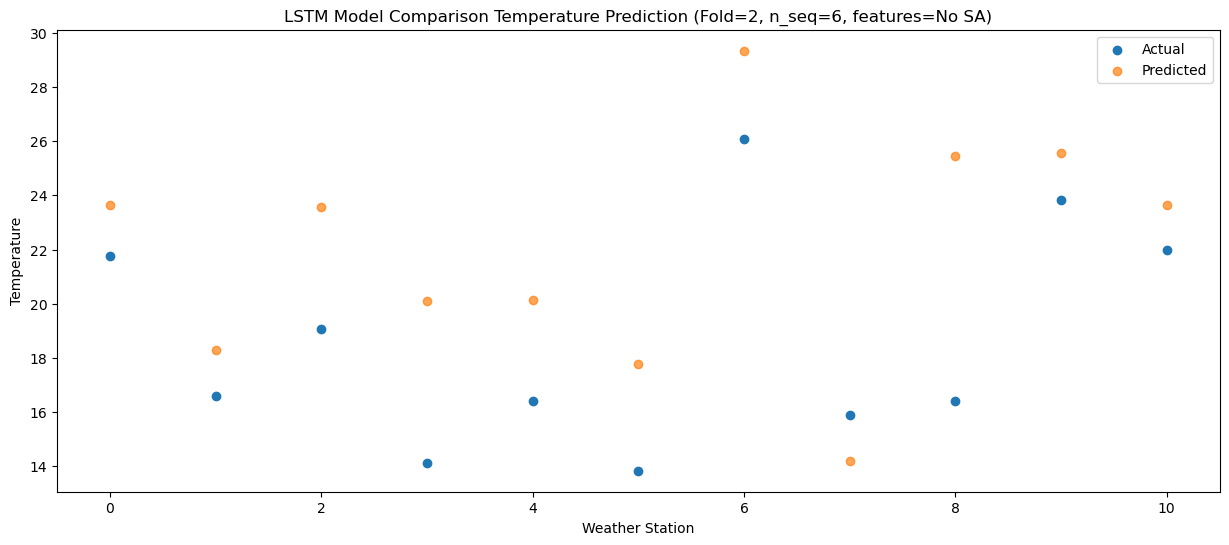

Predictions for (t+4):
    Weather_Station  Actual  Predicted
0                 0   26.55  28.380499
1                 1   21.78  23.010497
2                 2   22.63  28.280497
3                 3   19.38  24.810495
4                 4   20.89  24.850497
5                 5   17.88  22.520495
6                 6   30.16  34.060495
7                 7   20.91  18.920495
8                 8   18.64  30.180497
9                 9   27.83  30.290499
10               10   26.91  28.380497


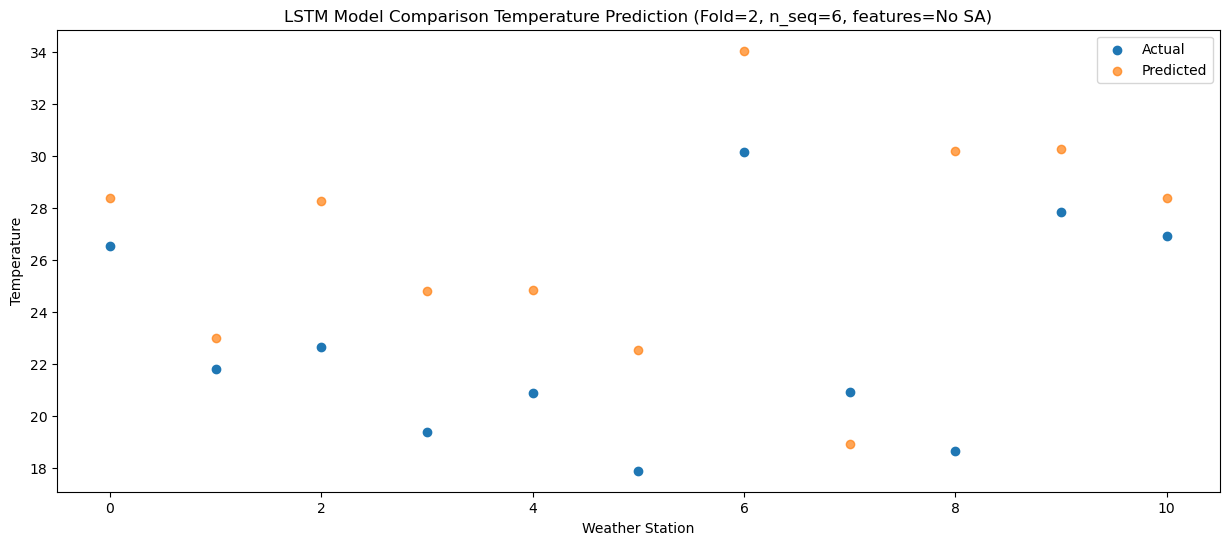

Predictions for (t+5):
    Weather_Station  Actual  Predicted
0                 0   31.80  35.020042
1                 1   29.03  29.650040
2                 2   23.85  34.920040
3                 3   24.95  31.450038
4                 4   24.37  31.490040
5                 5   22.43  29.160038
6                 6   35.72  40.700038
7                 7   25.90  25.560038
8                 8   22.88  36.820040
9                 9   32.12  36.930042
10               10   32.32  35.020040


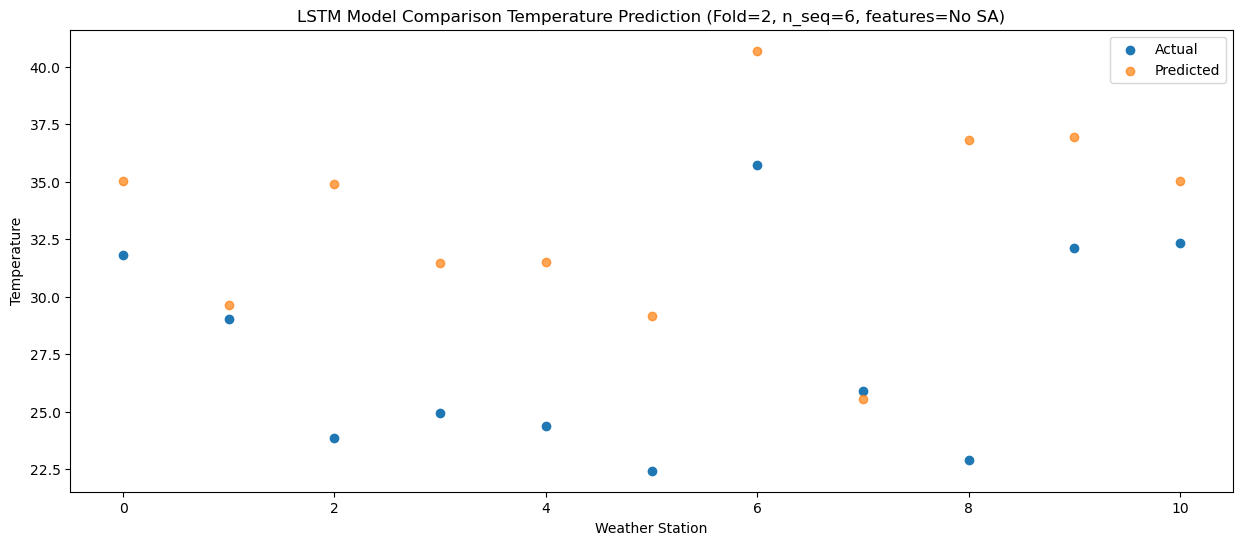

Model: "sequential_505"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1010 (LSTM)            (1, 1, 256)               2279424   
                                                                 
 dropout_1010 (Dropout)      (1, 1, 256)               0         
                                                                 
 lstm_1011 (LSTM)            (1, 256)                  525312    
                                                                 
 dropout_1011 (Dropout)      (1, 256)                  0         
                                                                 
 dense_1515 (Dense)          (1, 256)                  65792     
                                                                 
 dense_1516 (Dense)          (1, 128)                  32896     
                                                                 
 dense_1517 (Dense)          (1, 6)                 

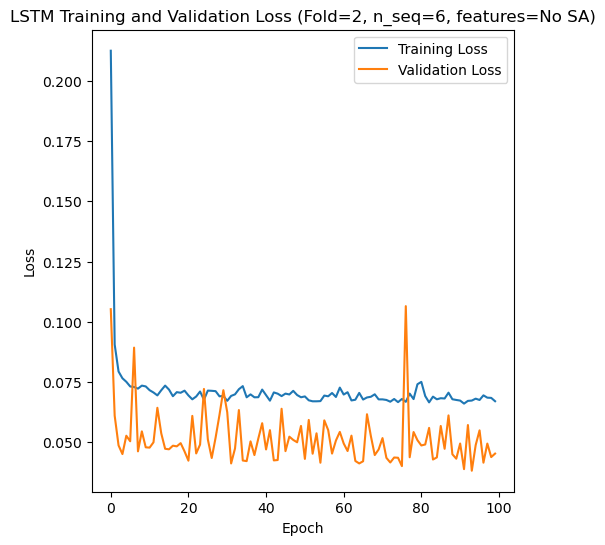

Epoch 1/100
84/84 [==============================] - 35s 122ms/step - loss: 0.1910 - accuracy: 0.5119 - mae: 0.1595 - rmse: 0.1910 - mape: 27.7970 - pearson: 0.5145 - val_loss: 0.0783 - val_accuracy: 0.7000 - val_mae: 0.0609 - val_rmse: 0.0783 - val_mape: 12.3321 - val_pearson: 0.7618
Epoch 2/100
84/84 [==============================] - 3s 39ms/step - loss: 0.0908 - accuracy: 0.7738 - mae: 0.0753 - rmse: 0.0908 - mape: 13.5169 - pearson: 0.7904 - val_loss: 0.0913 - val_accuracy: 0.7000 - val_mae: 0.0723 - val_rmse: 0.0913 - val_mape: 14.2004 - val_pearson: 0.6808
Epoch 3/100
84/84 [==============================] - 4s 42ms/step - loss: 0.0802 - accuracy: 0.7857 - mae: 0.0673 - rmse: 0.0802 - mape: 12.1812 - pearson: 0.7940 - val_loss: 0.0832 - val_accuracy: 0.7000 - val_mae: 0.0672 - val_rmse: 0.0832 - val_mape: 13.5687 - val_pearson: 0.7506
Epoch 4/100
84/84 [==============================] - 3s 40ms/step - loss: 0.0777 - accuracy: 0.7857 - mae: 0.0632 - rmse: 0.0777 - mape: 11.5621 -

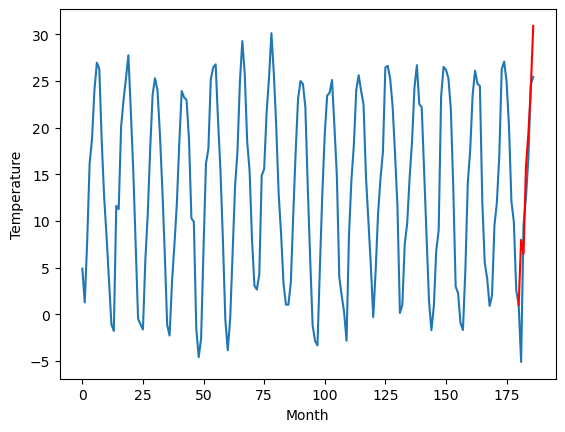

Weather Station 2:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
8.34		6.29		-2.05
11.77		4.78		-6.99
13.37		14.13		0.76
14.81		17.72		2.91
18.85		22.55		3.70
20.48		29.23		8.75
[180, 181, 182, 183, 184, 185, 186]
[14.25, 6.288292183876037, 4.7792582654953, 14.129244341850281, 17.7157337808609, 22.547394528388978, 29.22554184436798]


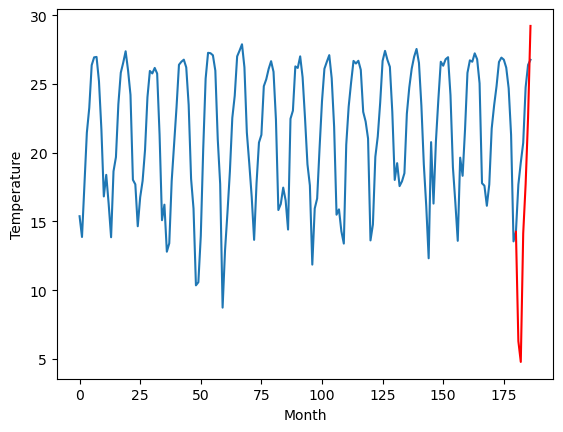

Weather Station 3:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
4.29		2.91		-1.38
2.37		1.40		-0.97
11.70		10.75		-0.95
12.77		14.34		1.57
17.24		19.17		1.93
21.50		25.85		4.35
[180, 181, 182, 183, 184, 185, 186]
[9.06, 2.9082921838760374, 1.3992582654953, 10.74924434185028, 14.3357337808609, 19.167394528388975, 25.84554184436798]


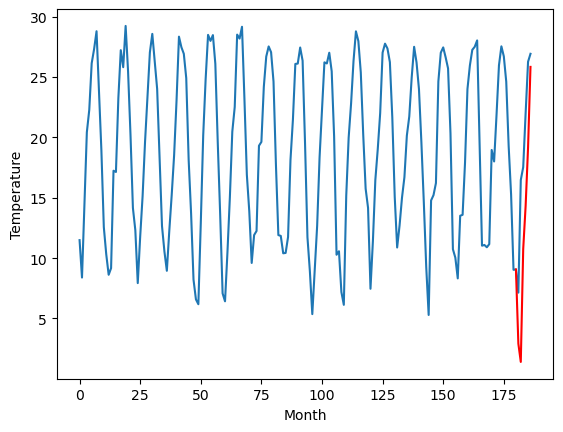

Weather Station 4:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
2.70		2.27		-0.43
-0.76		0.76		1.52
10.20		10.11		-0.09
11.89		13.70		1.81
16.05		18.53		2.48
21.73		25.21		3.48
[180, 181, 182, 183, 184, 185, 186]
[7.48, 2.2682921838760377, 0.7592582654953004, 10.109244341850282, 13.695733780860902, 18.527394528388978, 25.205541844367982]


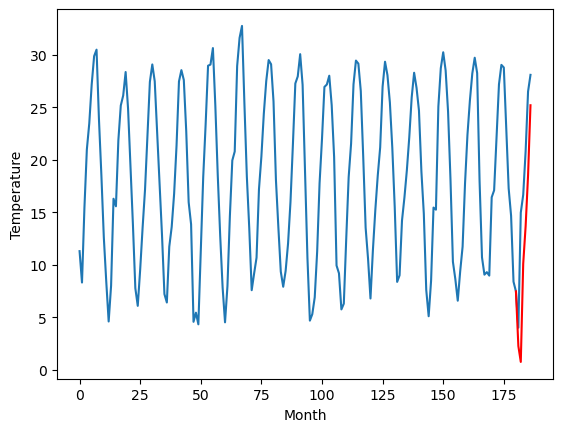

Weather Station 5:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
4.29		3.54		-0.75
0.40		2.03		1.63
11.32		11.38		0.06
13.50		14.97		1.47
17.03		19.80		2.77
23.88		26.48		2.60
[180, 181, 182, 183, 184, 185, 186]
[7.33, 3.5382921838760373, 2.0292602920532223, 11.379246368408204, 14.965735807418824, 19.7973965549469, 26.475543870925904]


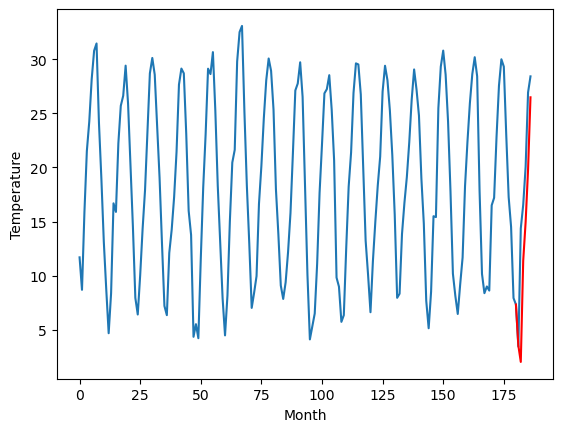

Weather Station 6:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
14.28		14.03		-0.25
12.71		12.52		-0.19
21.96		21.87		-0.09
24.19		25.46		1.27
29.68		30.29		0.61
34.64		36.97		2.33
[180, 181, 182, 183, 184, 185, 186]
[6.59, 14.028292183876038, 12.519258265495301, 21.869244341850283, 25.455733780860903, 30.28739452838898, 36.96554184436798]


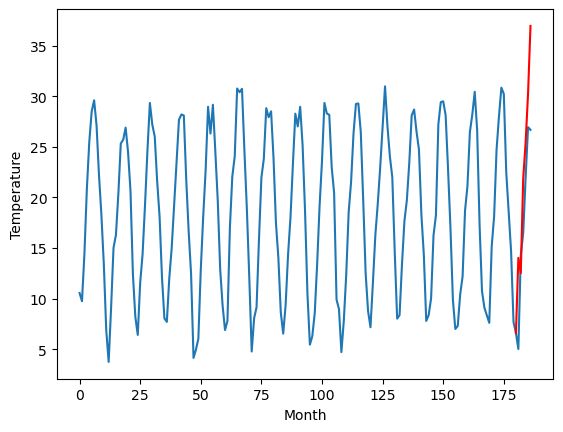

Weather Station 7:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
11.72		10.14		-1.58
12.39		8.63		-3.76
18.79		17.98		-0.81
21.52		21.57		0.05
24.97		26.40		1.43
28.99		33.08		4.09
[180, 181, 182, 183, 184, 185, 186]
[6.04, 10.138292183876038, 8.6292582654953, 17.979244341850283, 21.565733780860903, 26.39739452838898, 33.07554184436798]


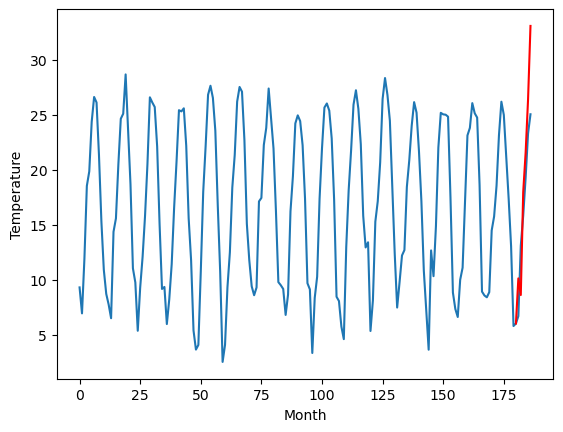

Weather Station 8:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
9.64		9.96		0.32
6.03		8.45		2.42
18.30		17.80		-0.50
20.20		21.39		1.19
24.24		26.22		1.98
30.54		32.90		2.36
[180, 181, 182, 183, 184, 185, 186]
[3.13, 9.958292183876038, 8.449260292053223, 17.799246368408205, 21.385735807418826, 26.2173965549469, 32.895543870925906]


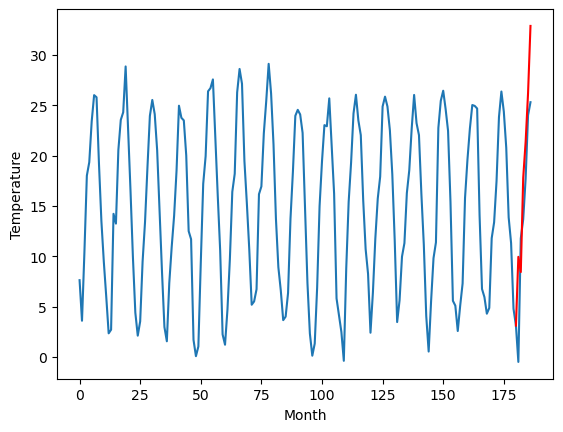

Weather Station 9:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
10.11		10.34		0.23
6.75		8.83		2.08
18.72		18.18		-0.54
22.37		21.77		-0.60
26.78		26.60		-0.18
34.02		33.28		-0.74
[180, 181, 182, 183, 184, 185, 186]
[-0.29, 10.338292183876037, 8.829260292053222, 18.1792463684082, 21.76573580741882, 26.597396554946897, 33.2755438709259]


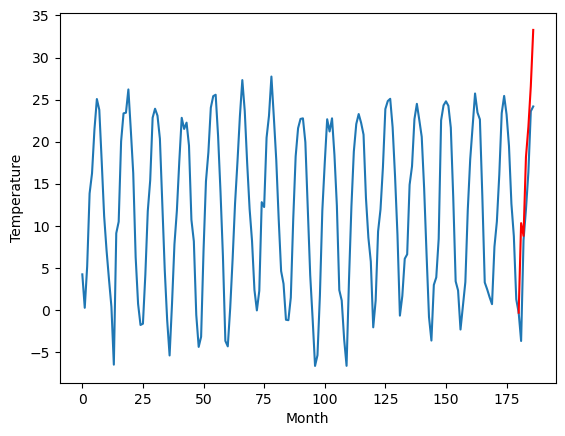

Weather Station 10:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
8.53		9.21		0.68
4.09		7.70		3.61
17.95		17.05		-0.90
21.66		20.64		-1.02
26.44		25.47		-0.97
33.83		32.15		-1.68
[180, 181, 182, 183, 184, 185, 186]
[-1.03, 9.208292183876038, 7.699260292053223, 17.049246368408205, 20.635735807418826, 25.4673965549469, 32.145543870925906]


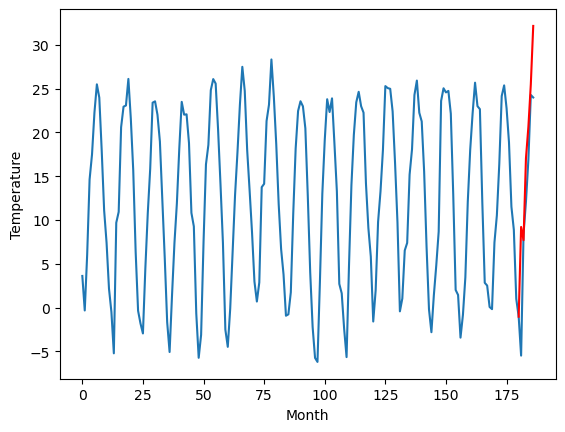

Weather Station 11:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
7.40		7.97		0.57
5.16		6.46		1.30
15.05		15.81		0.76
18.85		19.40		0.55
23.38		24.23		0.85
30.27		30.91		0.64
[180, 181, 182, 183, 184, 185, 186]
[-2.29, 7.968292183876038, 6.459260292053223, 15.809246368408203, 19.395735807418824, 24.2273965549469, 30.905543870925904]


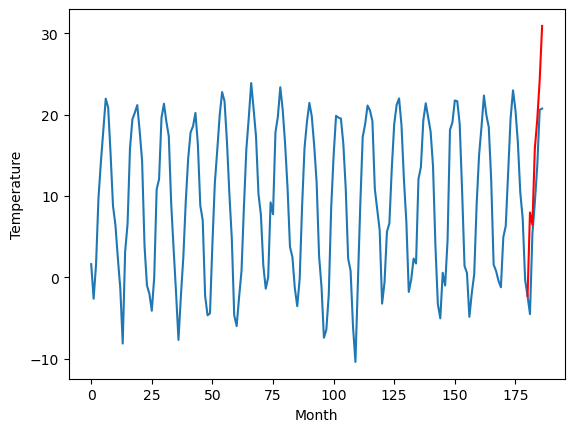

RangeIndex(start=1, stop=12, step=1)
[7.810000000000001, 8.339999999999998, 4.290000000000002, 2.7000000000000006, 4.289999999999999, 14.280000000000001, 11.719999999999999, 9.64, 10.11, 8.53, 7.4]
[7.968292183876038, 6.288292183876037, 2.9082921838760374, 2.2682921838760377, 3.5382921838760373, 14.028292183876038, 10.138292183876038, 9.958292183876038, 10.338292183876037, 9.208292183876038, 7.968292183876038]
Predictions for (t+0):
    Weather_Station  Actual  Predicted
0                 0    7.81   7.968292
1                 1    8.34   6.288292
2                 2    4.29   2.908292
3                 3    2.70   2.268292
4                 4    4.29   3.538292
5                 5   14.28  14.028292
6                 6   11.72  10.138292
7                 7    9.64   9.958292
8                 8   10.11  10.338292
9                 9    8.53   9.208292
10               10    7.40   7.968292


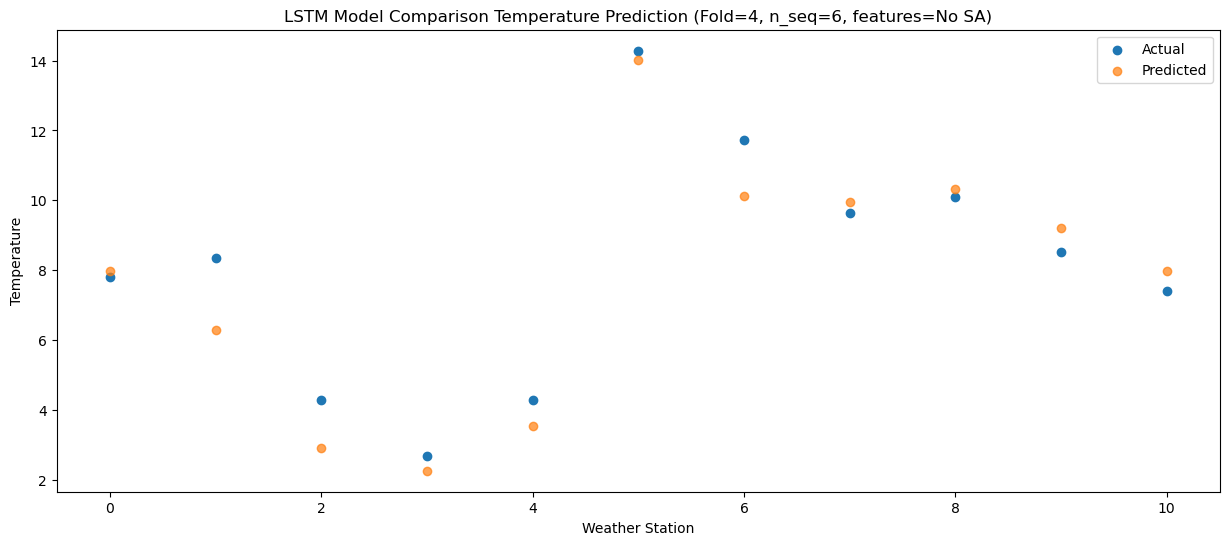

Predictions for (t+1):
    Weather_Station  Actual  Predicted
0                 0    1.68   6.459260
1                 1   11.77   4.779258
2                 2    2.37   1.399258
3                 3   -0.76   0.759258
4                 4    0.40   2.029260
5                 5   12.71  12.519258
6                 6   12.39   8.629258
7                 7    6.03   8.449260
8                 8    6.75   8.829260
9                 9    4.09   7.699260
10               10    5.16   6.459260


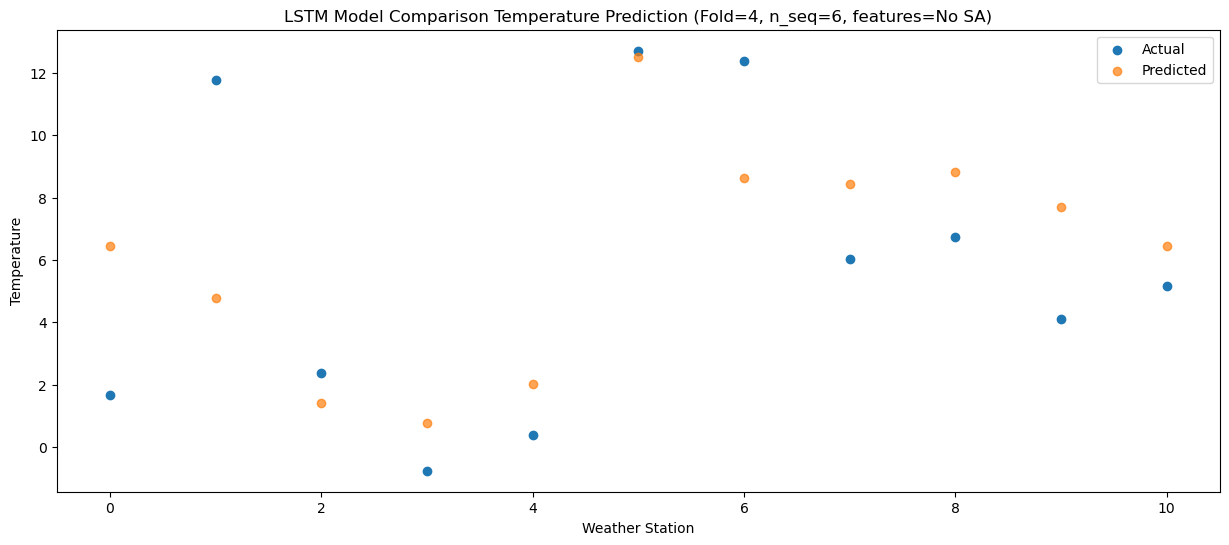

Predictions for (t+2):
    Weather_Station  Actual  Predicted
0                 0   16.41  15.809246
1                 1   13.37  14.129244
2                 2   11.70  10.749244
3                 3   10.20  10.109244
4                 4   11.32  11.379246
5                 5   21.96  21.869244
6                 6   18.79  17.979244
7                 7   18.30  17.799246
8                 8   18.72  18.179246
9                 9   17.95  17.049246
10               10   15.05  15.809246


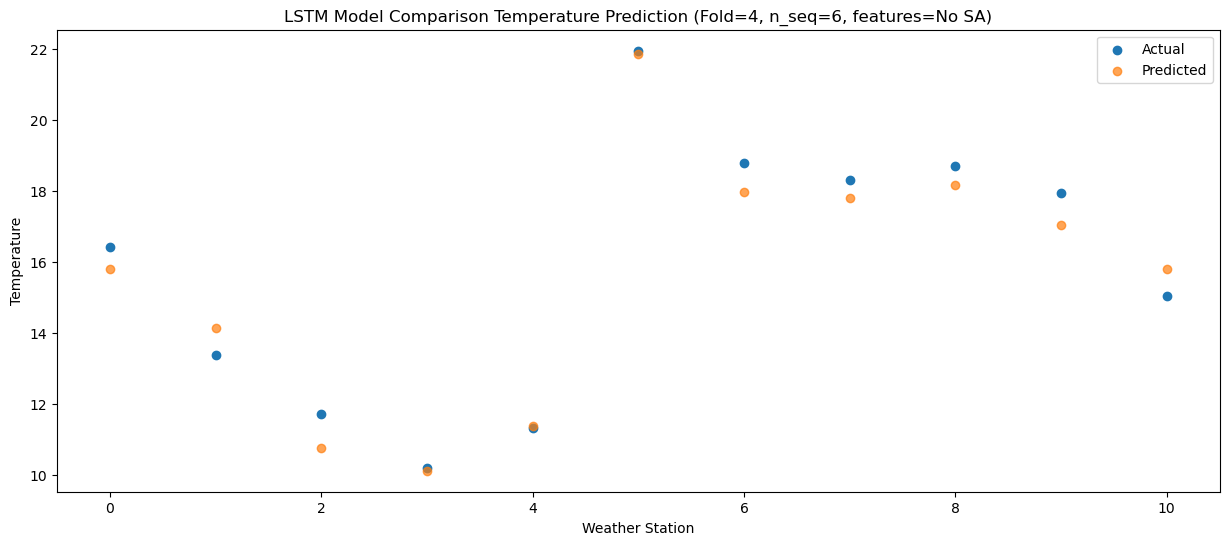

Predictions for (t+3):
    Weather_Station  Actual  Predicted
0                 0   19.32  19.395736
1                 1   14.81  17.715734
2                 2   12.77  14.335734
3                 3   11.89  13.695734
4                 4   13.50  14.965736
5                 5   24.19  25.455734
6                 6   21.52  21.565734
7                 7   20.20  21.385736
8                 8   22.37  21.765736
9                 9   21.66  20.635736
10               10   18.85  19.395736


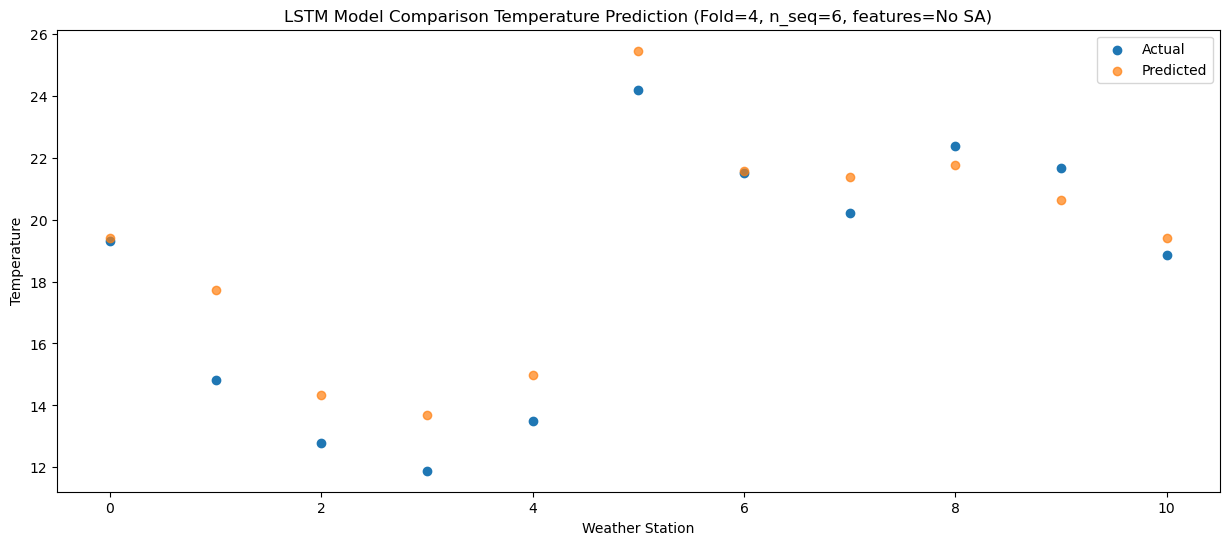

Predictions for (t+4):
    Weather_Station  Actual  Predicted
0                 0   23.53  24.227397
1                 1   18.85  22.547395
2                 2   17.24  19.167395
3                 3   16.05  18.527395
4                 4   17.03  19.797397
5                 5   29.68  30.287395
6                 6   24.97  26.397395
7                 7   24.24  26.217397
8                 8   26.78  26.597397
9                 9   26.44  25.467397
10               10   23.38  24.227397


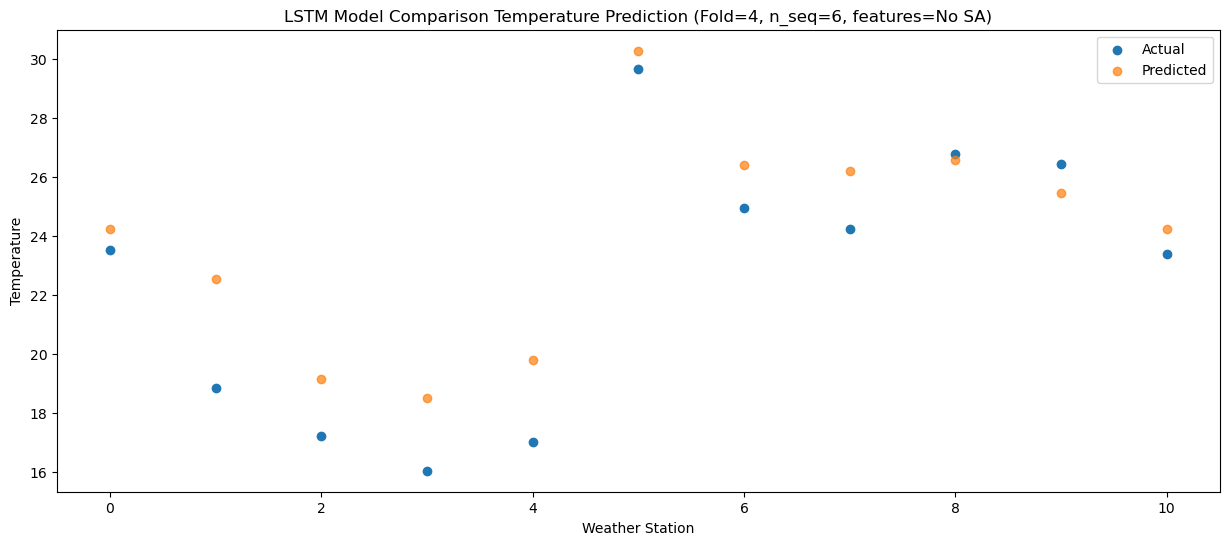

Predictions for (t+5):
    Weather_Station  Actual  Predicted
0                 0   31.44  30.905544
1                 1   20.48  29.225542
2                 2   21.50  25.845542
3                 3   21.73  25.205542
4                 4   23.88  26.475544
5                 5   34.64  36.965542
6                 6   28.99  33.075542
7                 7   30.54  32.895544
8                 8   34.02  33.275544
9                 9   33.83  32.145544
10               10   30.27  30.905544


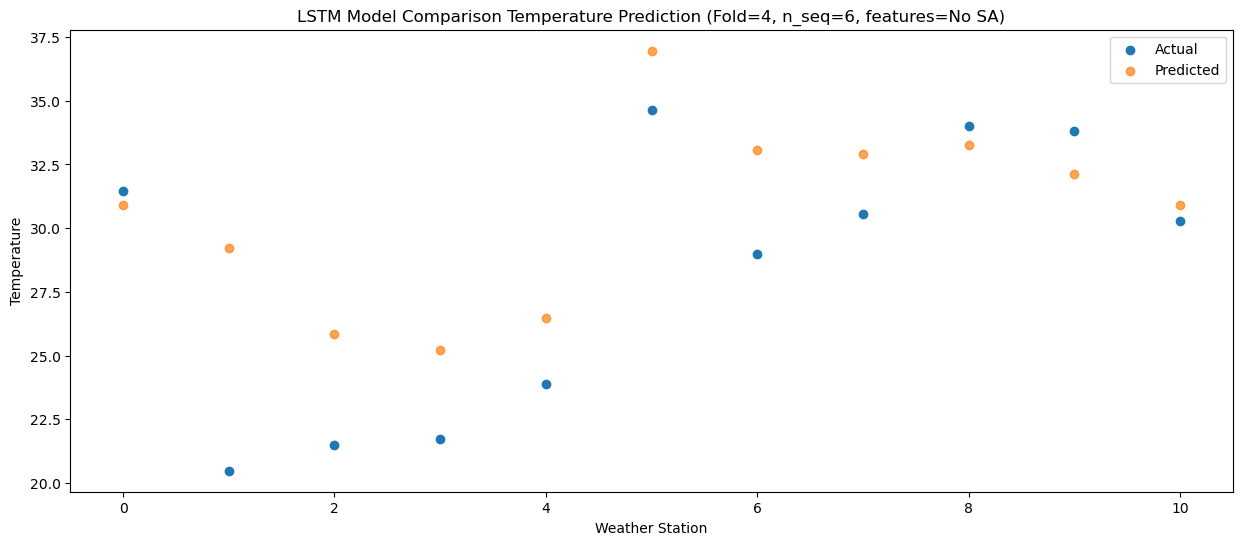

Model: "sequential_507"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1014 (LSTM)            (1, 1, 256)               2279424   
                                                                 
 dropout_1014 (Dropout)      (1, 1, 256)               0         
                                                                 
 lstm_1015 (LSTM)            (1, 256)                  525312    
                                                                 
 dropout_1015 (Dropout)      (1, 256)                  0         
                                                                 
 dense_1521 (Dense)          (1, 256)                  65792     
                                                                 
 dense_1522 (Dense)          (1, 128)                  32896     
                                                                 
 dense_1523 (Dense)          (1, 6)                 

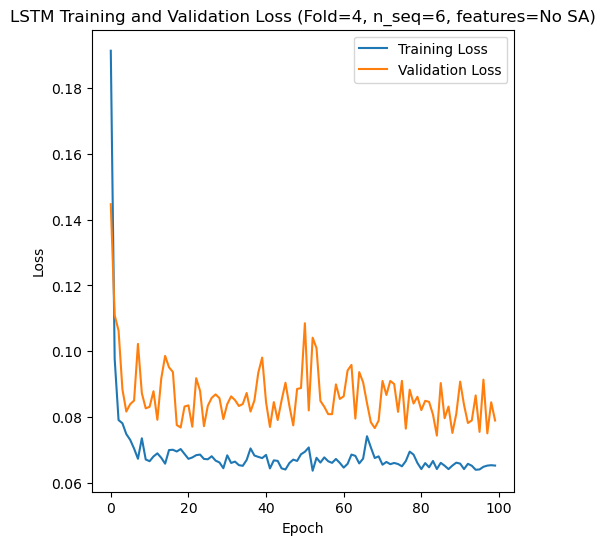

[[1.5184766481275287, 3.2494190100354032, 2.7195748651652747, 1.244084303007616, 1.4856185615446067, 2.4962252035045807], [1.117809614945523, 2.7467566105044083, 1.6653073864069796, 0.9044534104646522, 0.972086877508694, 2.3345784470738664], [1.0036265048125488, 3.0437943411870636, 3.7440087760864253, 4.182746259365124, 4.899670009158488, 6.883481809198101], [1.8500558068806898, 5.079991614634173, 2.429326226182368, 3.0223487118178, 3.1149369558227185, 4.108972242848361], [0.9721921861754096, 3.256982916713915, 0.6360090128555759, 1.3827451564531377, 1.8993244744625717, 3.642102612941029]]
[[1.267062494104559, 2.5954934180866593, 2.5266615425456664, 1.0183373130451567, 1.226794592250478, 2.2056543185494166], [1.0525649898702445, 2.32186345317147, 1.4388283005627724, 0.7403790053454314, 0.8487166929244997, 2.056985806985333], [0.7317254220355646, 2.5489052666317336, 2.5153030293638055, 3.5533830714225756, 4.009497295943173, 5.6391234330697495], [1.5189746900038281, 4.042730122479526, 2.

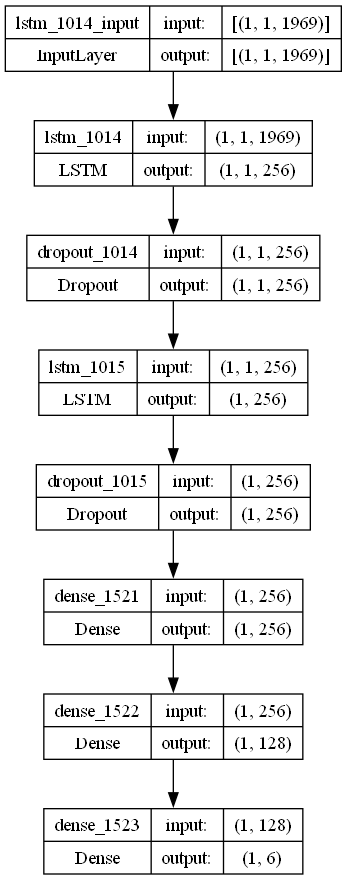

In [11]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
from tensorflow.keras.utils import plot_model

def rmse (y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

# fit the best LSTM model using parameters found by Optuna
def create_best_model(X, y, n_lag, n_seq, n_batch, nb_epoch):
    
    #Parameters:
    #trial (array-like): Optuna parameters.
    #train (array-like): Target values.
    #n_lag (int): Number of lag observations.
    #n_seq (int): Number of sequence observations
    #nb_epoch (int): Maximum number of epochs
    
    # Hyperparameters from the best model
    lr = 0.0036702828800194488
    optimizer = Adam(learning_rate = lr)
    activation_function = 'tanh'
    lstm_units = 256
    dropout_rate = 0.17556384197400268

    # design network
    model = Sequential()
    model.add(LSTM(lstm_units, return_sequences=True, batch_input_shape=(n_batch, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(lstm_units))
    model.add(Dropout(dropout_rate))
    model.add(Dense(256, input_dim=y.shape[1], activation=activation_function))
    model.add(Dense(128, activation=activation_function))
    model.add(Dense(n_seq))
    model.compile(loss=rmse, optimizer=optimizer, metrics=['accuracy', 'mae', rmse, mape, pearson])
        
    return model

# make one forecast with an LSTM,
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def forecast_lstm(model, X, n_seq, n_test):
    # reshape input pattern to [samples, timesteps, features]
    X = X.reshape(1, 1, X.shape[1])
    # make forecast
    forecast = model.predict(X)
    # convert to array
    return forecast
     
# evaluate the persistence model
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def make_forecasts(model, X_test, y_test, n_lag, n_seq, n_test):
    forecasts = list()
    for i in range(len(X_test)):
        X, y = X_test[i, :], y_test[i, :]
        # make forecast
        forecast = forecast_lstm(model, X, n_seq, n_test)
        # store the forecast
        forecasts.append(forecast)
    return forecasts
     
# invert differenced forecast
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def inverse_difference(last_ob, forecast):
    # invert first forecast
    inverted = list()
    inverted.append(forecast[0] + last_ob)
    # propagate difference forecast using inverted first value
    for i in range(1, len(forecast)):
        inverted.append(forecast[i] + inverted[i-1])
    return inverted
     
# inverse data transform on forecasts
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def inverse_transform(series, forecasts, scaler, n_test, n_seq):
    inverted = list()
    for i in range(len(forecasts)):
        # create array from forecast
        forecast = forecasts[i]
        forecast = forecast.reshape(1, n_seq)
        # invert scaling
        inv_scale = scaler.inverse_transform(forecast)
        inv_scale = inv_scale[0, :]
        # invert differencing
        index = len(series) - n_test + i - 1
        last_ob = series.values[index]
        inv_diff = inverse_difference(last_ob, inv_scale)
        # store
        inverted.append(inv_diff)
    return inverted
     
# evaluate the RMSE for each forecast time step
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def evaluate_forecasts(test, forecasts, n_lag, n_seq):
    rmse_list = []
    mae_list = []
    mape_list = []
    r2_list = []
    for i in range(n_seq):
        actual = [row[i] for row in test]
        predicted = [forecast[i] for forecast in forecasts]
        rmse = sqrt(mean_squared_error(actual, predicted))
        mae = mean_absolute_error(actual, predicted)
        mse = mean_squared_error(actual, predicted)
        mape = mean_absolute_percentage_error(actual, predicted)
        r2 = r2_score(actual, predicted) 
        rmse_list.append(rmse)
        mae_list.append(mae)
        mape_list.append(mape)
        r2_list.append(r2)
        print("Month at t+"+str(i+1)+":")
        print('t+%d RMSE: %f' % ((i+1), rmse))
        print('t+%d MAE: %f' % ((i+1), mae))
        print('t+%d MAPE: %f' % ((i+1), mape))
        print('t+%d R2_SCORE: %f' % ((i+1), r2))

    return rmse_list, mae_list, mape_list, r2_list
     
# plot the forecasts in the context of the original dataset
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def plot_forecasts(series, forecasts, n_test, n_seq, n_lag):
    # plot the entire dataset in blue
    plt.plot(series[:n_lag+2+len(forecasts)].values)
    # plot the forecasts in red
    off_s = n_lag + 1
    off_e = off_s + len(forecasts) + 1
    xaxis = [x for x in range(off_s, off_e)]
    yaxis = [series.values[off_s]] + forecasts
    print(xaxis)
    print(yaxis)
    plt.plot(xaxis, yaxis, color='red')
    plt.xlabel("Month")
    plt.ylabel("Temperature")
    # show the plot
    plt.show()

n_batch = 1
n_test = 11
nb_epoch = 100
    
rmse_avg_list = []
mae_avg_list = []
mape_avg_list = []
r2_score_avg_list = []
forecast_results = []
actual_results = []
    
for i in range(5):
    train1 = train[i]
    test1 = test[i]
    validation1 = validation[i]

    X = train1[:, 0:-n_seq]
    y = train1[:, -n_seq:]
    X_test = test1[:, 0:-n_seq]
    y_test = test1[:, -n_seq:]
    X_val = validation1[:, 0:-n_seq]
    y_val = validation1[:, -n_seq:]

    dataset_df = pd.DataFrame(val_y[i])
    dataset_df = dataset_df.iloc[0:10, :]
    dataset = dataset_df.values

    series = pd.Series(dataset[:, 0]) # Using first column (temperatures)

    X = X.reshape(X.shape[0], 1, X.shape[1])
    X1 = X_test
    X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
    X_val = X_val.reshape(X_val.shape[0], 1, X_val.shape[1])

    best_model = create_best_model(X, y, n_lag, n_seq, n_batch, nb_epoch)
    history = best_model.fit(X, y, epochs=100, batch_size=n_batch, validation_data=(X_val, y_val))

    # Evaluate the model
    loss = best_model.evaluate(X_test, y_test, verbose=2)
    print(f'Test Loss: {loss}')

    # make forecasts
    forecasts = make_forecasts(best_model, X_test, y_test, n_lag, n_seq, n_test)
    
    # inverse transform forecasts and test
    forecasts = inverse_transform(series, forecasts, scaler[i], n_test+2, n_seq)
    actual = [row[-n_seq:] for row in test1]
    actual = inverse_transform(series, actual, scaler[i], n_test+2, n_seq)

    rmse_list = [] # list stores root mean squared errors for each future time prediction
    mae_list = [] # list stores root mean squared errors for each future time prediction
    mape_list = [] # list stores root mean squared errors for each future time prediction
    r2_list = [] # list stores root mean squared errors for each future time prediction

    # evaluate forecasts
    rmse_list, mae_list, mape_list, r2_list = evaluate_forecasts(actual, forecasts, n_lag, n_seq)

    rmse_avg_list.append(rmse_list)
    mae_avg_list.append(mae_list)
    mape_avg_list.append(mape_list)
    r2_score_avg_list.append(r2_list)
    forecast_results.append(forecasts)
    actual_results.append(actual)

    for j in range(11):
        print("Weather Station "+str(j+1)+":")
        print("Actual Temp\tPredicted Temp\tDifference")
        print("-----------\t--------------\t----------")
        for k in range(n_seq):
            diff = forecasts[j][k] - actual[j][k]
            print(f"{actual[j][k]:.2f}\t\t{forecasts[j][k]:.2f}\t\t{diff:.2f}")
    
        # plot forecasts
        dataset_df = pd.DataFrame(val_y[i])
        dataset_df = dataset_df.iloc[0:11, :]
        dataset_df = dataset_df.transpose()
        dataset = dataset_df.values

        series_ws = pd.Series(dataset[:, j]) # Using first column (temperatures)
        forecasts_ws = forecasts[j]
        
        plot_forecasts(series_ws, forecasts_ws, n_test, n_seq, n_lag)

    # Print out plots of actual and predicted values for weather stations
    ws = df.index[1:12]
    print(ws)
    a = []
    f = []
    for q in range(len(actual)):
        x = actual[q]
        a.append(x[0])
    for q in range(len(forecasts)):
        x = forecasts[q]
        f.append(x[0])
    print(a)
    print(f)
    # Create a DataFrame for plotting
    results_df = pd.DataFrame({
        'ws': ws,
        'Actual': a,
        'Predicted': f
    })

    for k in range(n_seq):
        print("Predictions for (t+"+str(k)+"):")
        # Print out plots of actual and predicted values for each weather station
        results = []

        # Create a DataFrame for plotting
        for j in range(11):
            results.append([j, actual[j][k], forecasts[j][k]])
               
        results_df = pd.DataFrame(results)
        results_df.columns = ['Weather_Station', 'Actual', 'Predicted']

        print(results_df)
            
        # Plotting the results
        plt.figure(figsize=(15, 6))
        plt.scatter(results_df['Weather_Station'], results_df['Actual'], label='Actual')
        plt.scatter(results_df['Weather_Station'], results_df['Predicted'], label='Predicted', alpha=0.7)
        title1='LSTM Model Comparison Temperature Prediction (Fold='+str(i)+', n_seq='+str(n_seq)+', features=No SA)'
        plt.title(title1)
        plt.xlabel('Weather Station')
        plt.ylabel('Temperature')
        plt.legend()
        plt.show()

    best_model.summary()

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    title2 = 'LSTM Training and Validation Loss (Fold='+str(i)+', n_seq='+str(n_seq)+', features=No SA)'
    plt.title(title2)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper right')
    plt.show()

print(rmse_avg_list)
print(mae_avg_list)
print(mape_avg_list)
print(r2_score_avg_list)
print(forecast_results)
print(actual_results)
print("Accuracy Results:")
print("RMSE for each fold:")
print(rmse_avg_list)
print("Average RMSE:"+str(np.mean(rmse_avg_list)))
print("Average MAE:"+str(np.mean(mae_avg_list)))
print("Average MAPE:"+str(np.mean(mape_avg_list)))
print("Average R2 Score:"+str(np.mean(r2_score_avg_list)))

# Plot model architecture
filename = "lstm_model_optimized_CV_S6_No_SA.png"
plot_model(best_model, to_file=filename, show_shapes=True, show_layer_names=True)